<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Segmentación de Clientes con Clustering Jerárquico y DBSCAN

El objetivo de este caso-taller es analizar una base de datos ficticia sobre clientes de una tienda y buscar encontrar grupos de clientes que permitan generar estrategias de marketing focalizadas. La base se encuentra en los `Archivos de Laboratorio` en la carpeta `data` y cuenta con 200 observaciones y 5 variables:

- `Id_Cliente`: identificador de cliente.
- `Genero`: género del cliente: Mujer, Hombre
- `Edad`: edad en años
- `Ingreso`: ingresos anuales
- `Puntaje_Gasto`: es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos 

En la carpeta `data` se encuentra el archivo `datos_clientes.csv` cargue estos datos en su *cuaderno*. 

In [52]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.cluster import DBSCAN

In [54]:
import session_info

session_info.show(html=False)

-----
gower               NA
kneed               0.8.5
matplotlib          3.8.4
numpy               1.26.3
pandas              2.0.3
scipy               1.11.4
seaborn             0.13.2
session_info        1.0.0
sklearn             1.4.0
-----
IPython             8.14.0
jupyter_client      8.3.0
jupyter_core        5.3.1
-----
Python 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]
Windows-10-10.0.22621-SP0
-----
Session information updated at 2024-08-31 15:42


Esta es la session info necesaria para correr los datos:

### Session Information

| Package         | Version                                           |
|-----------------|---------------------------------------------------|
| matplotlib      | 3.8.4                                             |
| numpy           | 1.26.3                                            |
| pandas          | 2.0.3                                             |
| seaborn         | 0.13.2                                            |
| session_info    | 1.0.0                                             |
| IPython         | 8.14.0                                            |
| jupyter_client  | 8.3.0                                             |
| jupyter_core    | 5.3.1                                             |

| Python Version  | Info                                              |
|-----------------|---------------------------------------------------|
| Python          | 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)] |


Matplotlib y Seaborn deben estar en esa version para que corra


In [55]:
df_datos = pd.read_csv("./data/datos_clientes.csv")
df_datos.head()

,Id_Cliente,Genero,Edad,Ingreso,Puntaje_Gasto
0,1,Mujer,41,98115.05,39
1,2,Mujer,20,35458.14,75
2,3,Mujer,68,59872.08,55
3,4,Hombre,63,48508.93,51
4,5,Mujer,31,44431.11,54


Se cargan los datos en el notebook

### 2. Análisis preliminar. 

Antes de comenzar el análisis de segmentación utilice estadísticas descriptivas para explorar la variables que se encuentran en los datos. En su análisis mencione si hay patrones que surgen del examen descriptivo de los datos; entre ellos si hay diferencias en los ingresos y los puntajes de gastos para mujeres y hombres, por grupos etarios (18-24, 25-34, 35-44, 45-54, 55-64, y 65+), y por grupos etarios y género. Discuta además si estas diferencias son estadísticamente significativas.

In [56]:
# Utilice este espacio para escribir el código.
n,v = df_datos.shape
print("cantidad de datos: {n}, cantidad de vairables: {v}".format(n=n,v=v))

cantidad de datos: 200, cantidad de vairables: 5


In [57]:
#reporte de datos nulos
df_datos.isna().sum()

Id_Cliente       0
Genero           0
Edad             0
Ingreso          0
Puntaje_Gasto    0
dtype: int64

El dataset no tiene valores nulos y cuenta con 5 variables las cuales se listan a continuacion :
Variables Numericas
* **Id_Cliente**: identificador unico del cliente
* **Edad**: edad del cliente en años
* **Ingreso**: Ingresos anuales del cliente
* **Puntaje_Gasto**: variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto.
Variables Categoricas
* **Genero**: valor binario entre (Mujer, Hombre)

In [58]:
df_datos.describe()

,Id_Cliente,Edad,Ingreso,Puntaje_Gasto
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60624.446600,50.200000
std,57.879185,13.969007,26262.903416,25.823522
min,1.000000,18.000000,13458.020000,1.000000
25%,50.750000,28.750000,41512.787500,34.750000
50%,100.500000,36.000000,60777.960000,50.000000
75%,150.250000,49.000000,77143.865000,73.000000
max,200.000000,70.000000,138584.520000,99.000000


In [59]:
def rangos_etarios(row):
    edad = row
    if edad < 18:
        return '0. -18'
    elif edad <= 24:
        return '1. 18-24'
    elif edad <= 34:
        return '2. 25-34'
    elif edad <= 44:
        return '3. 35-44'
    elif edad <= 54:
        return '4. 45-54'
    elif edad <= 64:
        return '5. 55-64'
    elif edad >= 65:
        return '6. 65+'
    

# Aplicar la función a la columna 'Fecha de Llegada'
df_datos['rango_edades'] = df_datos['Edad'].apply(rangos_etarios)

#### Descripctiva variables generales
A continuacion la descripcion de cada variable de forma independiente

In [60]:
def describe_variables(df,variable,grupo=None):

    
    if grupo is None:
        col = variable
        display(df[[col]].describe().T)
        
        n_cols = 3
        n_rows = 1

        fig,ax =plt.subplots(n_rows,n_cols,figsize=(n_cols*8,n_rows*5))
        axs = ax.flatten()

        sns.histplot(data=df, x=col, color="seagreen",ax=axs[0])
        axs[0].set_title("Histograma de la variable: {}".format(col))

        sns.boxplot(data=df, x=col, color="seagreen",ax=axs[1])
        axs[1].set_title("Boxplot de la variable {}".format(col))

        sns.violinplot(data=df.sort_values(by=col), x=variable,ax=axs[2], inner="quart", color="seagreen")
        sns.swarmplot(data=df.sort_values(by=col), x=variable,ax=axs[2], color="white")
        axs[2].set_title("Dispersion de la variable {}".format(col))

        plt.show()
    
    else:
    
    
        col = grupo
        
        display(df.groupby(col)[[variable]].describe())

        vars = np.sort(df_datos[col].unique())

        n_cols = 2
        n_rows = int(np.ceil((len(vars)+ 2)/n_cols)) 

        fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*15,n_rows*6.5))
        axs = ax.flatten()

        for i,v in enumerate(vars):
            
            fltr = df[col] == v
            sns.histplot(data=df[fltr],x=variable, color="seagreen",ax=axs[i])
            axs[i].set_title("distribucion de variable {c} para los categoria: {i}".format(c=col, i = v))


        sns.boxplot(data=df.sort_values(by=col), x=variable, hue=col,ax=axs[i+1], y=col, legend=True)
        axs[i+1].set_title("Boxplot de la variable {}".format(col))
        sns.violinplot(data=df.sort_values(by=col), x=variable,ax=axs[i+2], y=col,hue=col, inner="quart")
        sns.swarmplot(data=df.sort_values(by=col), x=variable,ax=axs[i+2], y=col, color="white")
        axs[i+2].set_title("Dispersion de la variable {} por categorias".format(col))

    plt.show()

# def describe_variables_categ(df,col,grupo=None):

#     if grupo is None:
#         gr = df.groupby(col).count()[["Id_Cliente"]]
#         gr["pct"] = np.round(100*gr/gr.sum(),2)
#         gr = gr.reset_index()
#         display(gr)

#         order = gr[col].tolist()

#         fig,ax =plt.subplots(1,1,figsize=(8,5))
#         sns.barplot(data=df, x=col, y="Id_Cliente", color="seagreen",ax=ax , order=order,errorbar=None)
#         ax.set_title("Grafica de Barras de la variable: {}".format(col))

#         plt.show()
#     else:
#         gr = df.groupby([col,grupo]).count()[["Id_Cliente"]].reset_index()
#         display(gr)

#         order = gr[col].unique()
        
#         fig,ax =plt.subplots(1,1,figsize=(8,5))
#         sns.barplot(data=df.sort_values(by=col), x=col, y="Id_Cliente", color="seagreen",ax=ax, hue=grupo, order=order, errorbar=None)
#         ax.set_title("Grafica de Barras de la variable {a}, agrupada por {b}".format(a=col, b = grupo))

#         plt.show()

In [61]:
def describe_variables_categ(df, col, grupo=None):
    if grupo is None:
        # Contar el número de ocurrencias por categoría
        gr = df.groupby(col).size().reset_index(name='count')
        gr['pct'] = np.round(100 * gr['count'] / gr['count'].sum(), 2)
        gr = gr.sort_values(by='count', ascending=False)  # Ordenar por conteo
        
        # Mostrar los datos en el orden correcto
        display(gr)

        # Crear el gráfico de barras
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        sns.barplot(data=gr, x=col, y='count', color='seagreen', ax=ax, order=gr[col], errorbar=None)
        ax.set_title(f"Gráfica de Barras de la variable: {col}")
        plt.show()
    else:
        # Contar el número de ocurrencias por categoría y grupo
        gr = df.groupby([col, grupo]).size().reset_index(name='count')
        gr = gr.sort_values(by='count', ascending=False)  # Ordenar por conteo

        # Mostrar los datos en el orden correcto
        display(gr)
        
        # Crear el gráfico de barras
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        sns.barplot(data=gr, x=col, y='count', hue=grupo, color='seagreen', ax=ax, order=gr[col].unique(), errorbar=None)
        ax.set_title(f"Gráfica de Barras de la variable {col}, agrupada por {grupo}")
        plt.show()

,count,mean,std,min,25%,50%,75%,max
Edad,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0


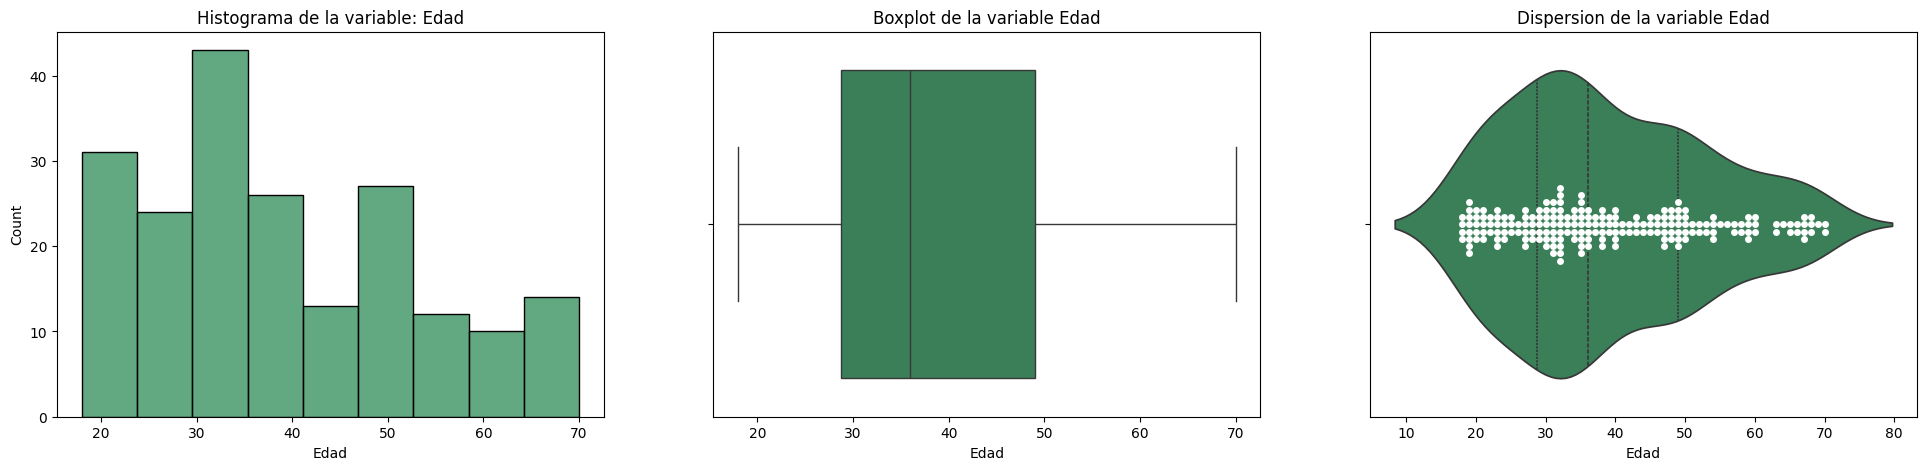

In [62]:
describe_variables(df_datos,variable="Edad")

Se tienen en este caso 200 datos de la variable edad con 38.5 años de media pasando de 18 años a 70 años

,rango_edades,count,pct
1,2. 25-34,54,27.0
2,3. 35-44,42,21.0
3,4. 45-54,39,19.5
0,1. 18-24,35,17.5
4,5. 55-64,16,8.0
5,6. 65+,14,7.0


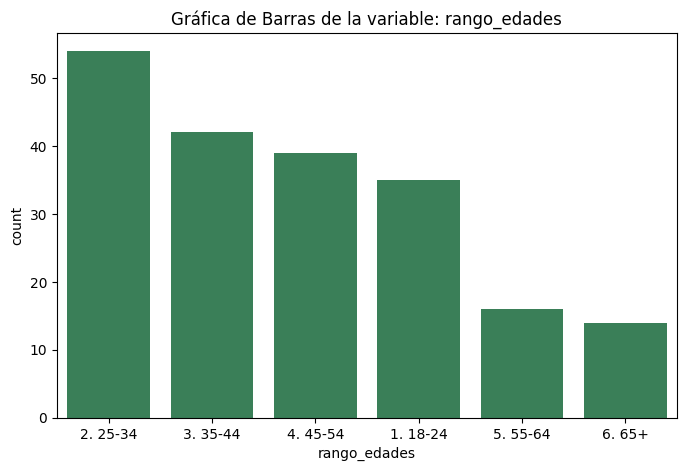

In [63]:
describe_variables_categ(df_datos, col="rango_edades")

Se puede ver como se ven los rangos de edades donde estan distribuidos de manera bastante equitativa

,count,mean,std,min,25%,50%,75%,max
Ingreso,200.0,60624.4466,26262.903416,13458.02,41512.7875,60777.96,77143.865,138584.52


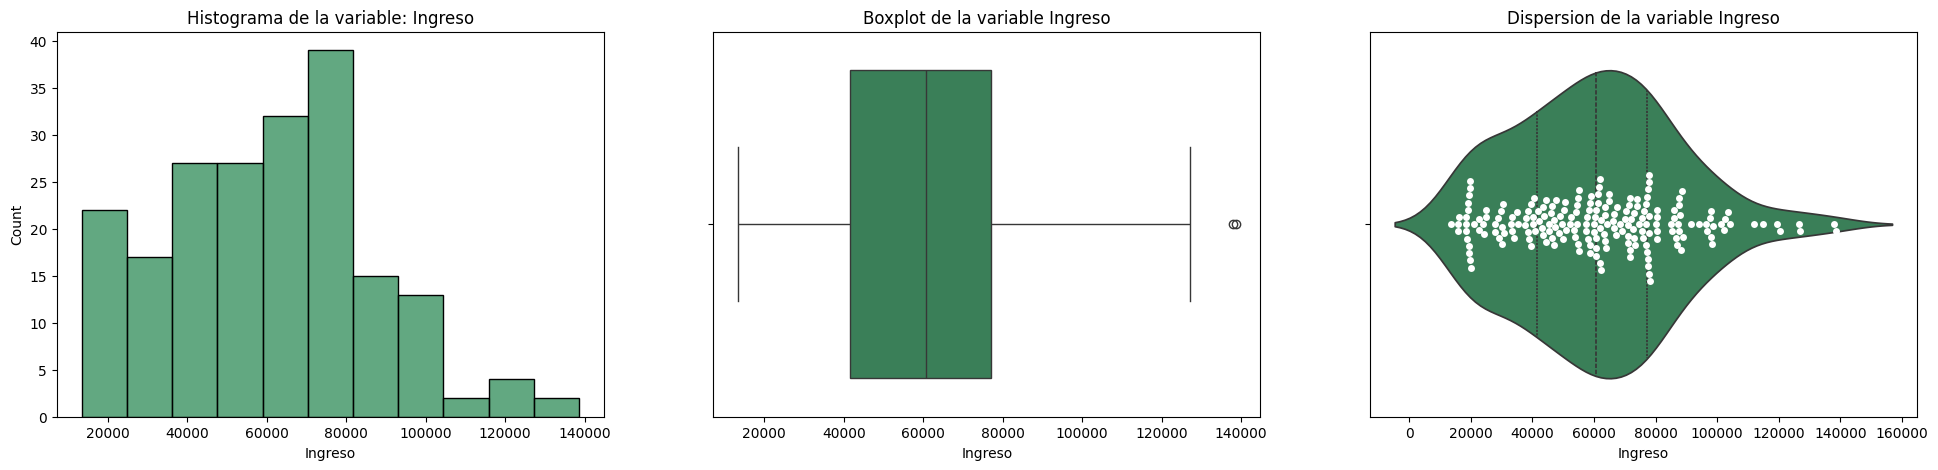

In [64]:
describe_variables(df_datos,variable="Ingreso")

Se ve entonces la distriibucion de la variable ingreso donde la media de ingreso es 60624.4 y como se ven algunos outliers

,count,mean,std,min,25%,50%,75%,max
Puntaje_Gasto,200.0,50.2,25.823522,1.0,34.75,50.0,73.0,99.0


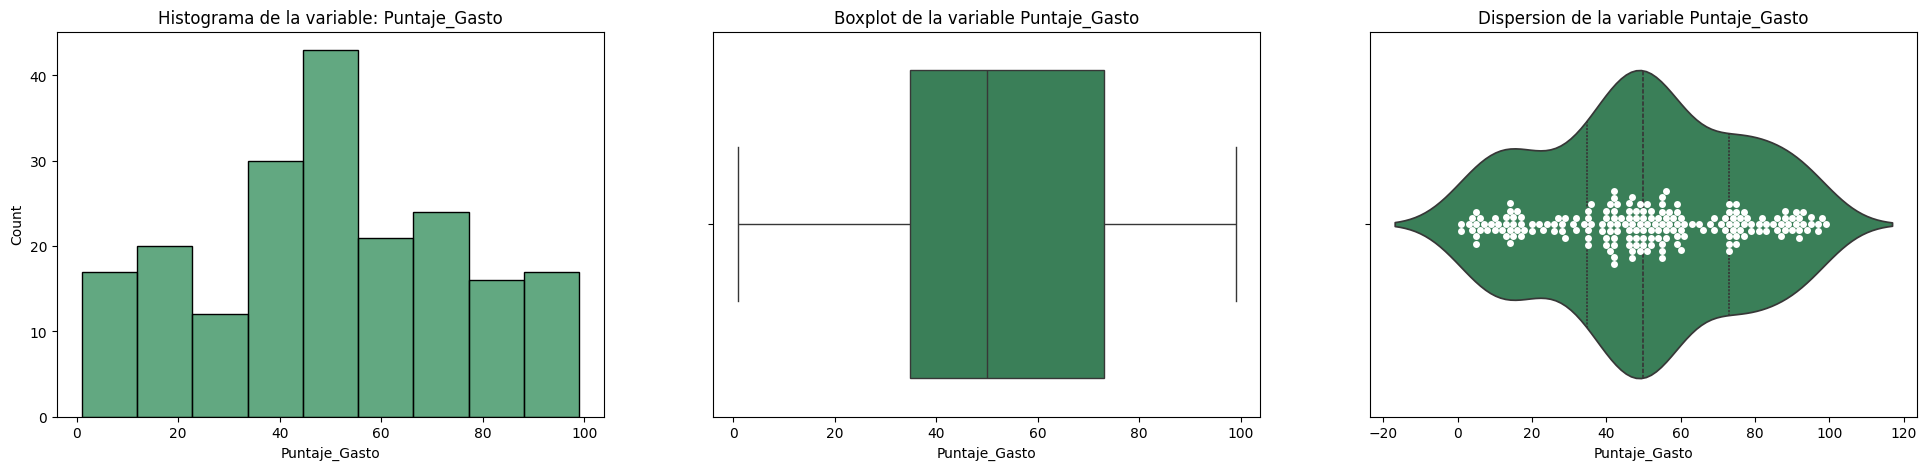

In [65]:
describe_variables(df_datos,variable="Puntaje_Gasto")

Tambien vemos la variable de puntaje gasto, recordemos que es una variable que mide cuán a menudo un cliente compra en la tienda, siendo 100 el puntaje más alto. Por lo que vemos la media es de 50.2

,Genero,count,pct
1,Mujer,112,56.0
0,Hombre,88,44.0


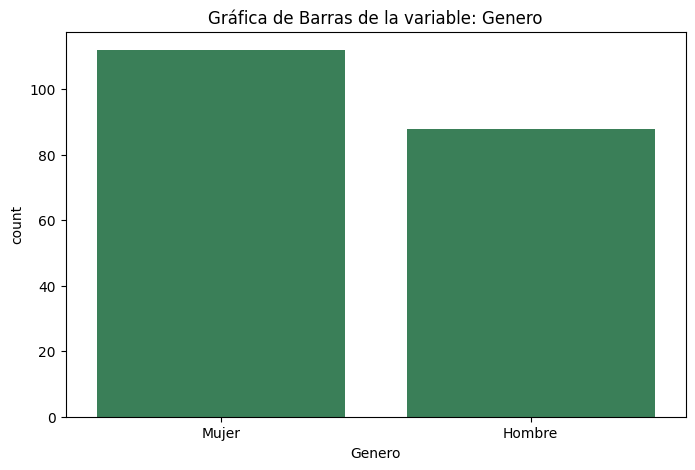

In [66]:
describe_variables_categ(df_datos, col="Genero")

In [67]:
df_datos["Genero"].value_counts()

Genero
Mujer     112
Hombre     88
Name: count, dtype: int64

Se puede ver que hay mas mujeres que hombres, 56% son mujeres en los datos y 44% hombres

#### Relacion entre variables

Ingreso                                                               \
         count          mean           std       min         25%        50%   
Genero                                                                        
Hombre    88.0  62126.660455  26765.492953  13458.02  45003.0800  61706.565   
Mujer    112.0  59444.135714  25920.459216  15766.84  40013.4125  59355.305   

                               
               75%        max  
Genero                         
Hombre  77731.3025  138584.52  
Mujer   76788.3875  126685.78

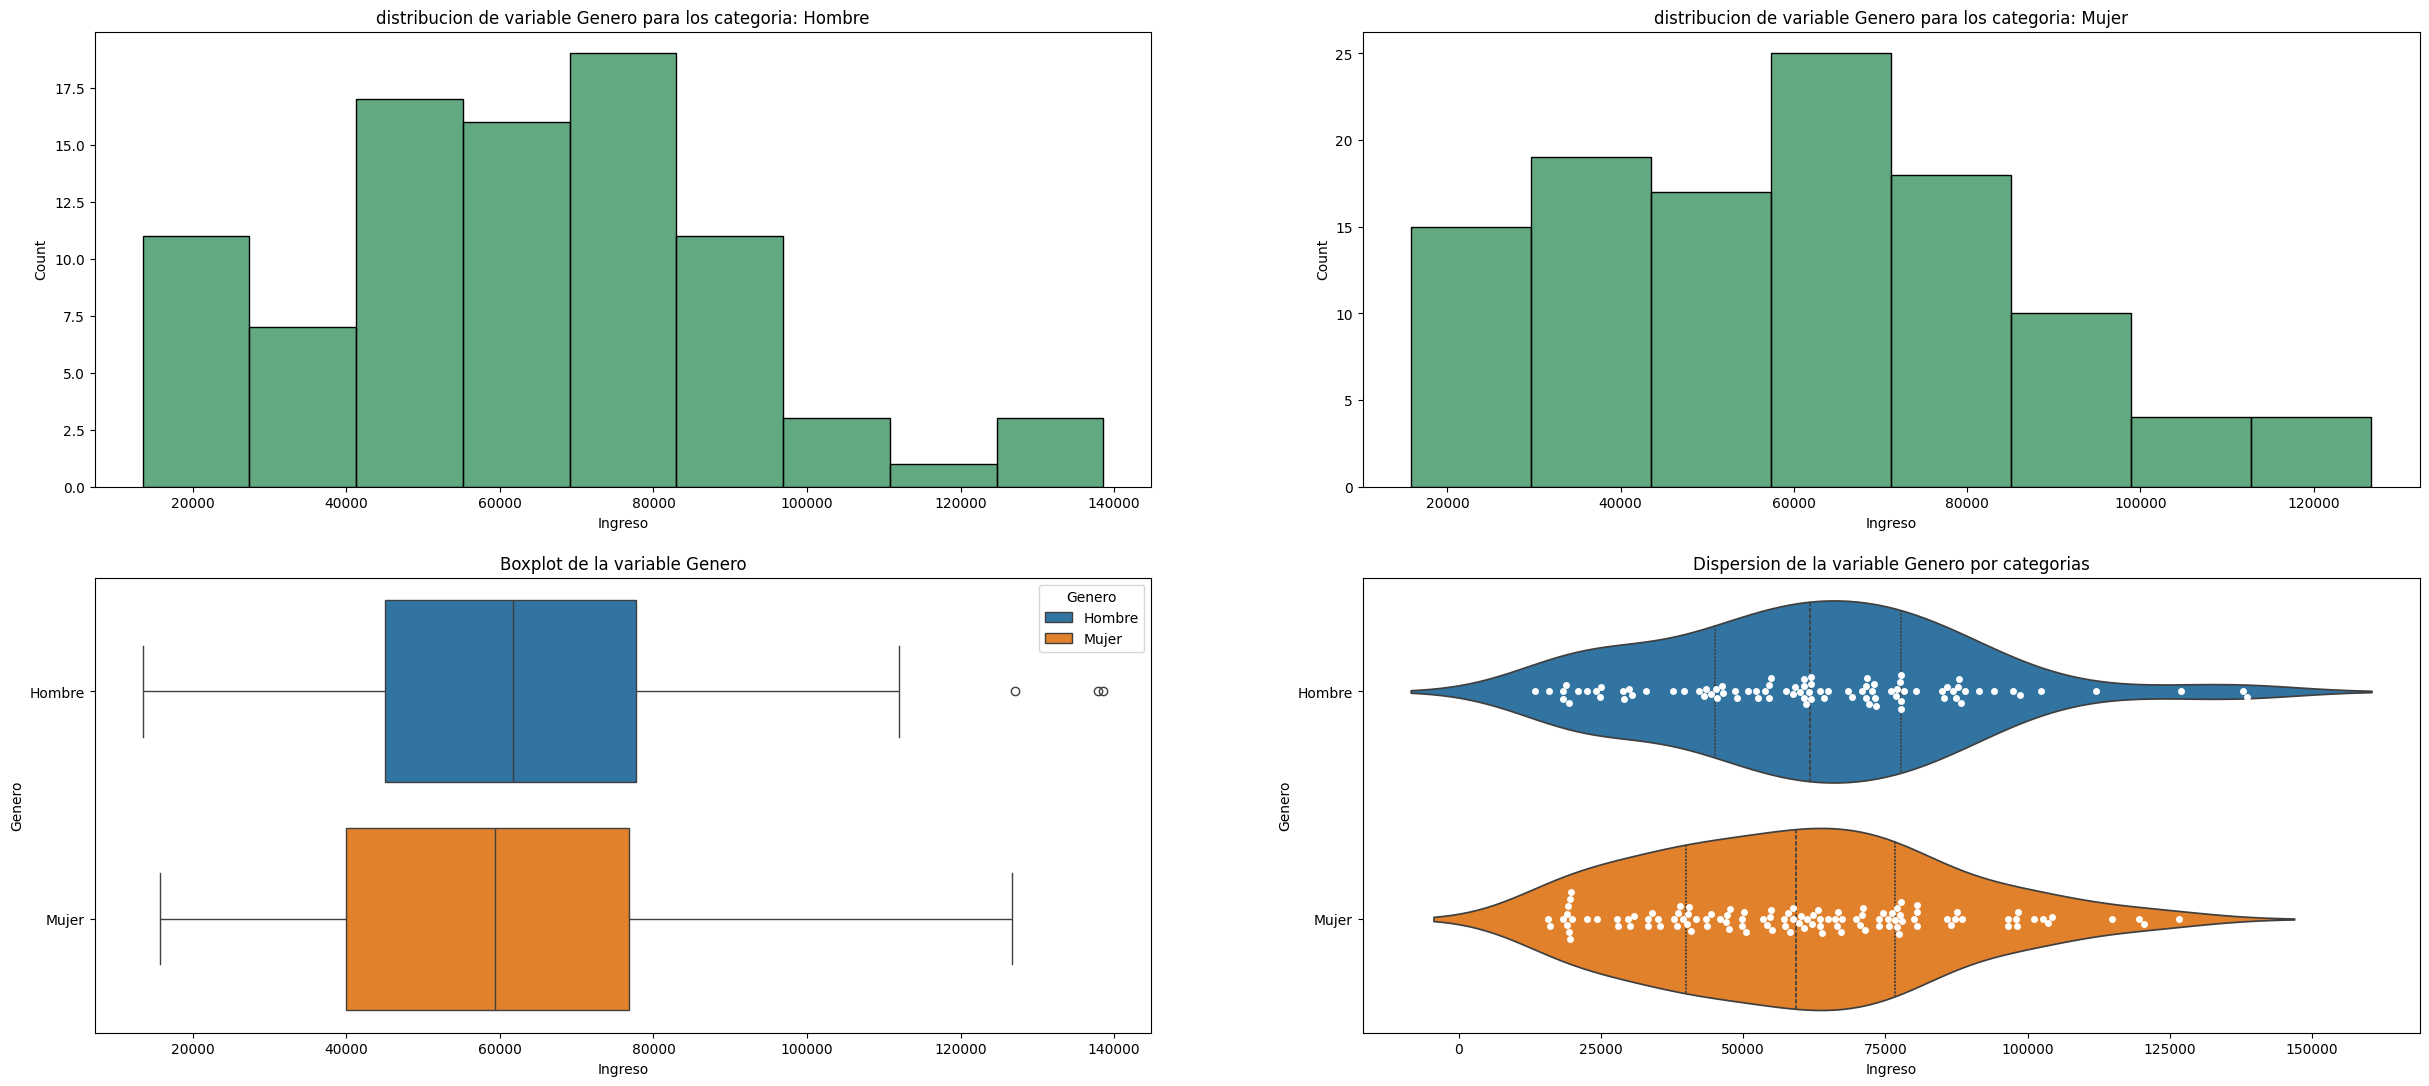

In [68]:
describe_variables(df_datos,"Ingreso",grupo="Genero")

Vemos entonces la distribucion de genero y sus ingresos, se ve entonces que el ingreso promedio para los hombres es mas alto, y tiene unos outliers que llegan a ingresos mucho mas altos


Ingreso                                                    \
               count          mean           std       min         25%   
rango_edades                                                             
1. 18-24        35.0  44454.795429  20378.208373  13458.02  24465.3200   
2. 25-34        54.0  71157.328148  27885.788157  19003.52  50141.6575   
3. 35-44        42.0  66957.096905  27722.049259  18797.16  50771.2225   
4. 45-54        39.0  58786.491026  24276.268114  24402.32  42447.5600   
5. 55-64        16.0  56357.093125  22351.828240  18434.74  46947.2075   
6. 65+          14.0  51420.789286  12686.437083  18437.21  45659.1800   

                                                
                    50%         75%        max  
rango_edades                                    
1. 18-24      46455.340  61564.3550   80360.65  
2. 25-34      75824.910  85872.9375  138584.52  
3. 35-44      71638.860  86762.7750  119534.68  
4. 45-54      55041.390  67337.0950  126685.78  
5. 55-64      54718.180  72384.2775   94049.49  
6. 65+        51546.645  61858.4675   64156.37

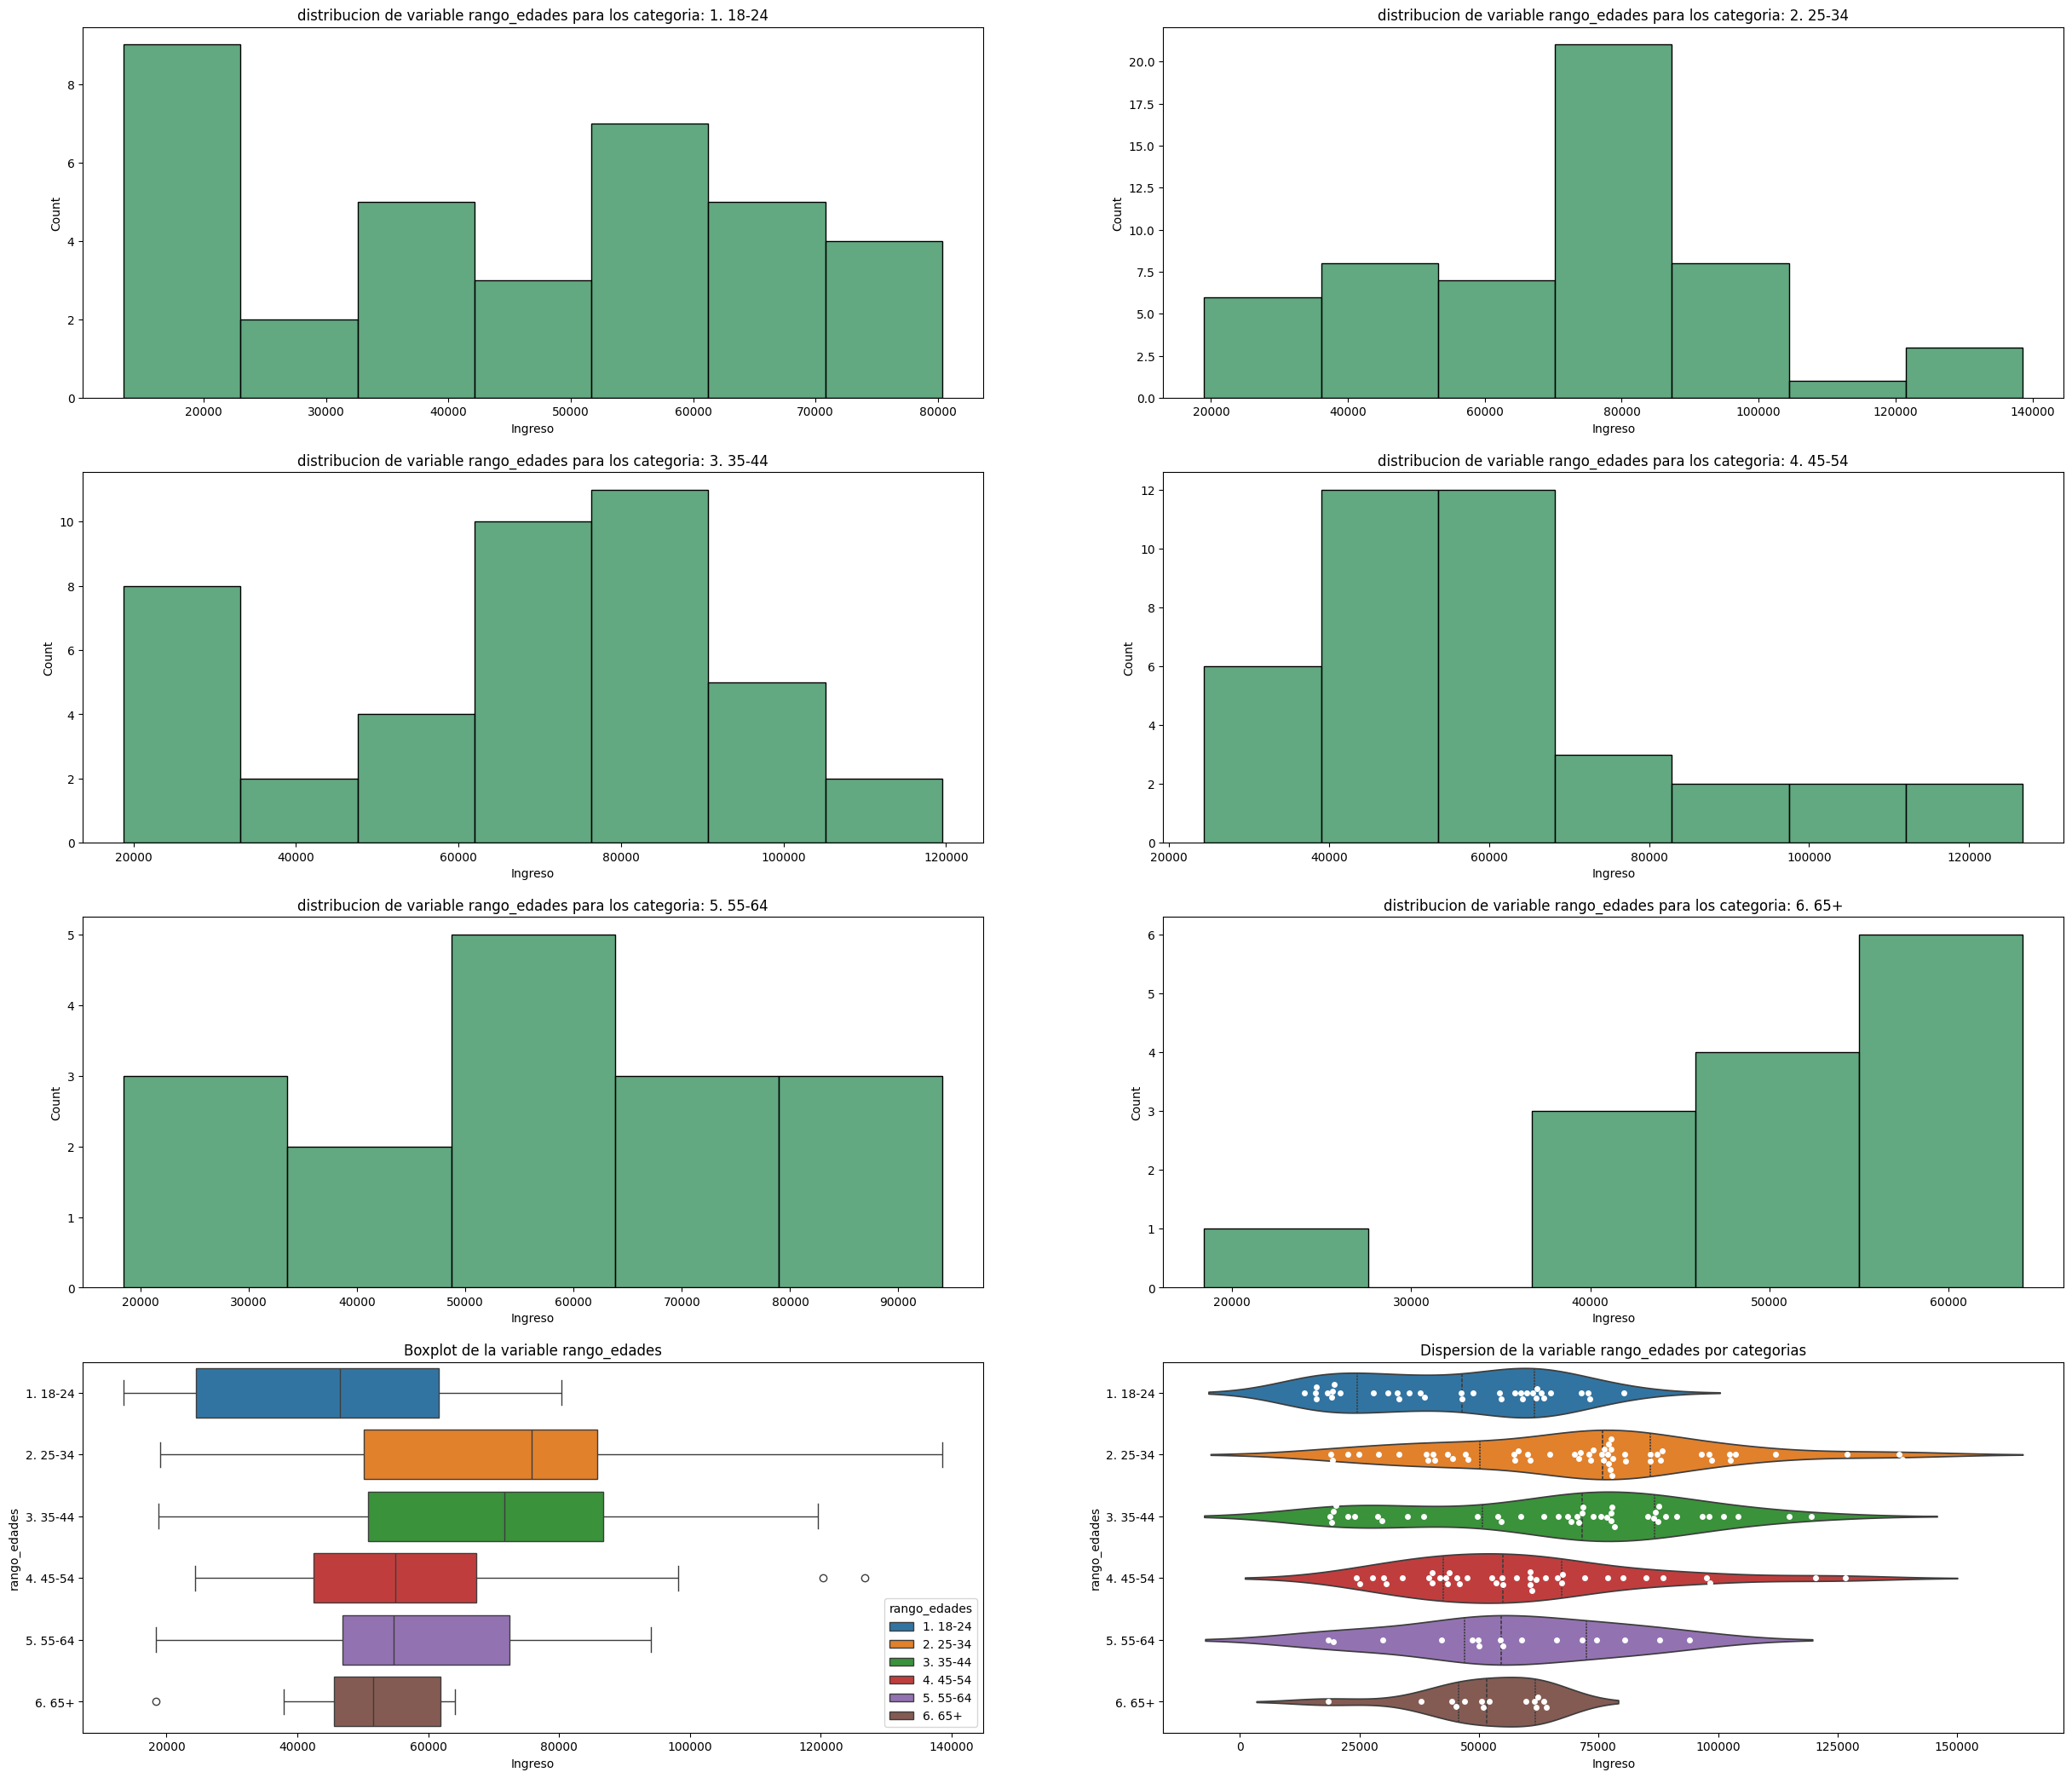

In [69]:
describe_variables(df_datos,"Ingreso",grupo="rango_edades")

Tambien vemos la distribucion de ingresos por rangos de edad. Vemos que ell rango de edad con mayores ingresos promedi es 25-34, asi como tambien los outliers con ingresos mas altos. El rango de edad con media mas baja es 18-24. 

Puntaje_Gasto                                                  
               count       mean       std  min   25%   50%   75%   max
Genero                                                                
Hombre          88.0  48.511364  27.89677  1.0  24.5  50.0  70.0  97.0
Mujer          112.0  51.526786  24.11495  5.0  35.0  50.0  73.0  99.0

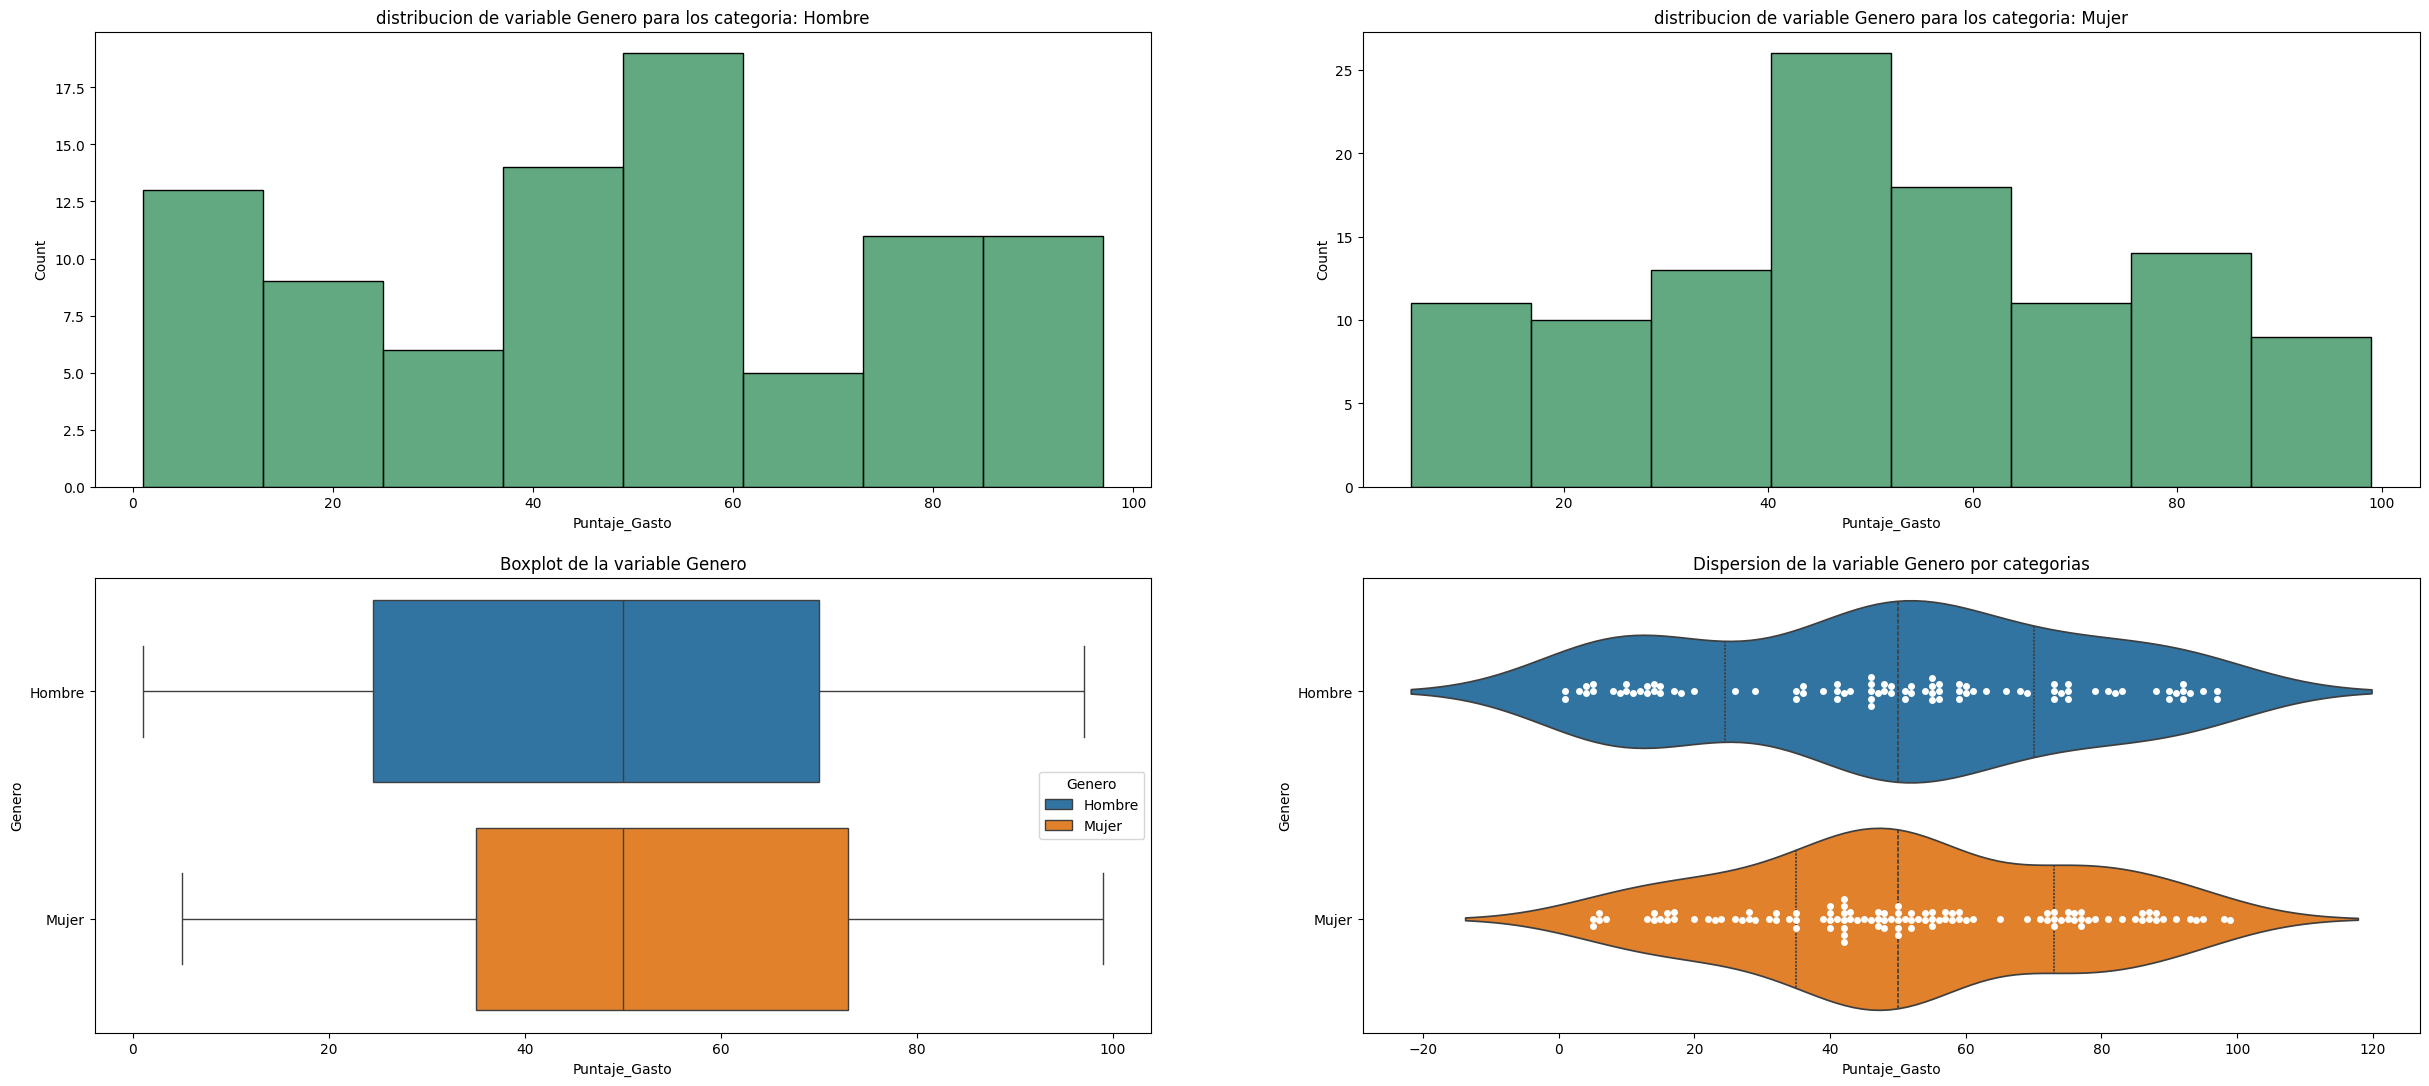

In [70]:
describe_variables(df_datos,"Puntaje_Gasto",grupo="Genero")

Ahora vemos el puntaje de gasto vs el genero. En promedio el genero no parece diferenciar fuertemente el gasto, pero la media es un poco mas alta para mujeres. Ademas tiene un max de 99 mientras que hombres tienen uno de  97. 

Puntaje_Gasto                                                  \
                     count       mean        std   min    25%   50%    75%   
rango_edades                                                                 
1. 18-24              35.0  56.257143  24.659258   5.0  44.00  55.0  76.50   
2. 25-34              54.0  63.166667  24.283506   1.0  47.75  70.0  82.75   
3. 35-44              42.0  49.428571  30.700078   1.0  21.50  41.0  75.75   
4. 45-54              39.0  36.230769  16.261776   4.0  25.00  42.0  47.50   
5. 55-64              16.0  32.312500  21.752299   3.0  13.25  39.0  51.00   
6. 65+                14.0  46.714286  11.431593  14.0  43.75  49.0  54.25   

                    
               max  
rango_edades        
1. 18-24      94.0  
2. 25-34      97.0  
3. 35-44      99.0  
4. 45-54      59.0  
5. 55-64      60.0  
6. 65+        59.0

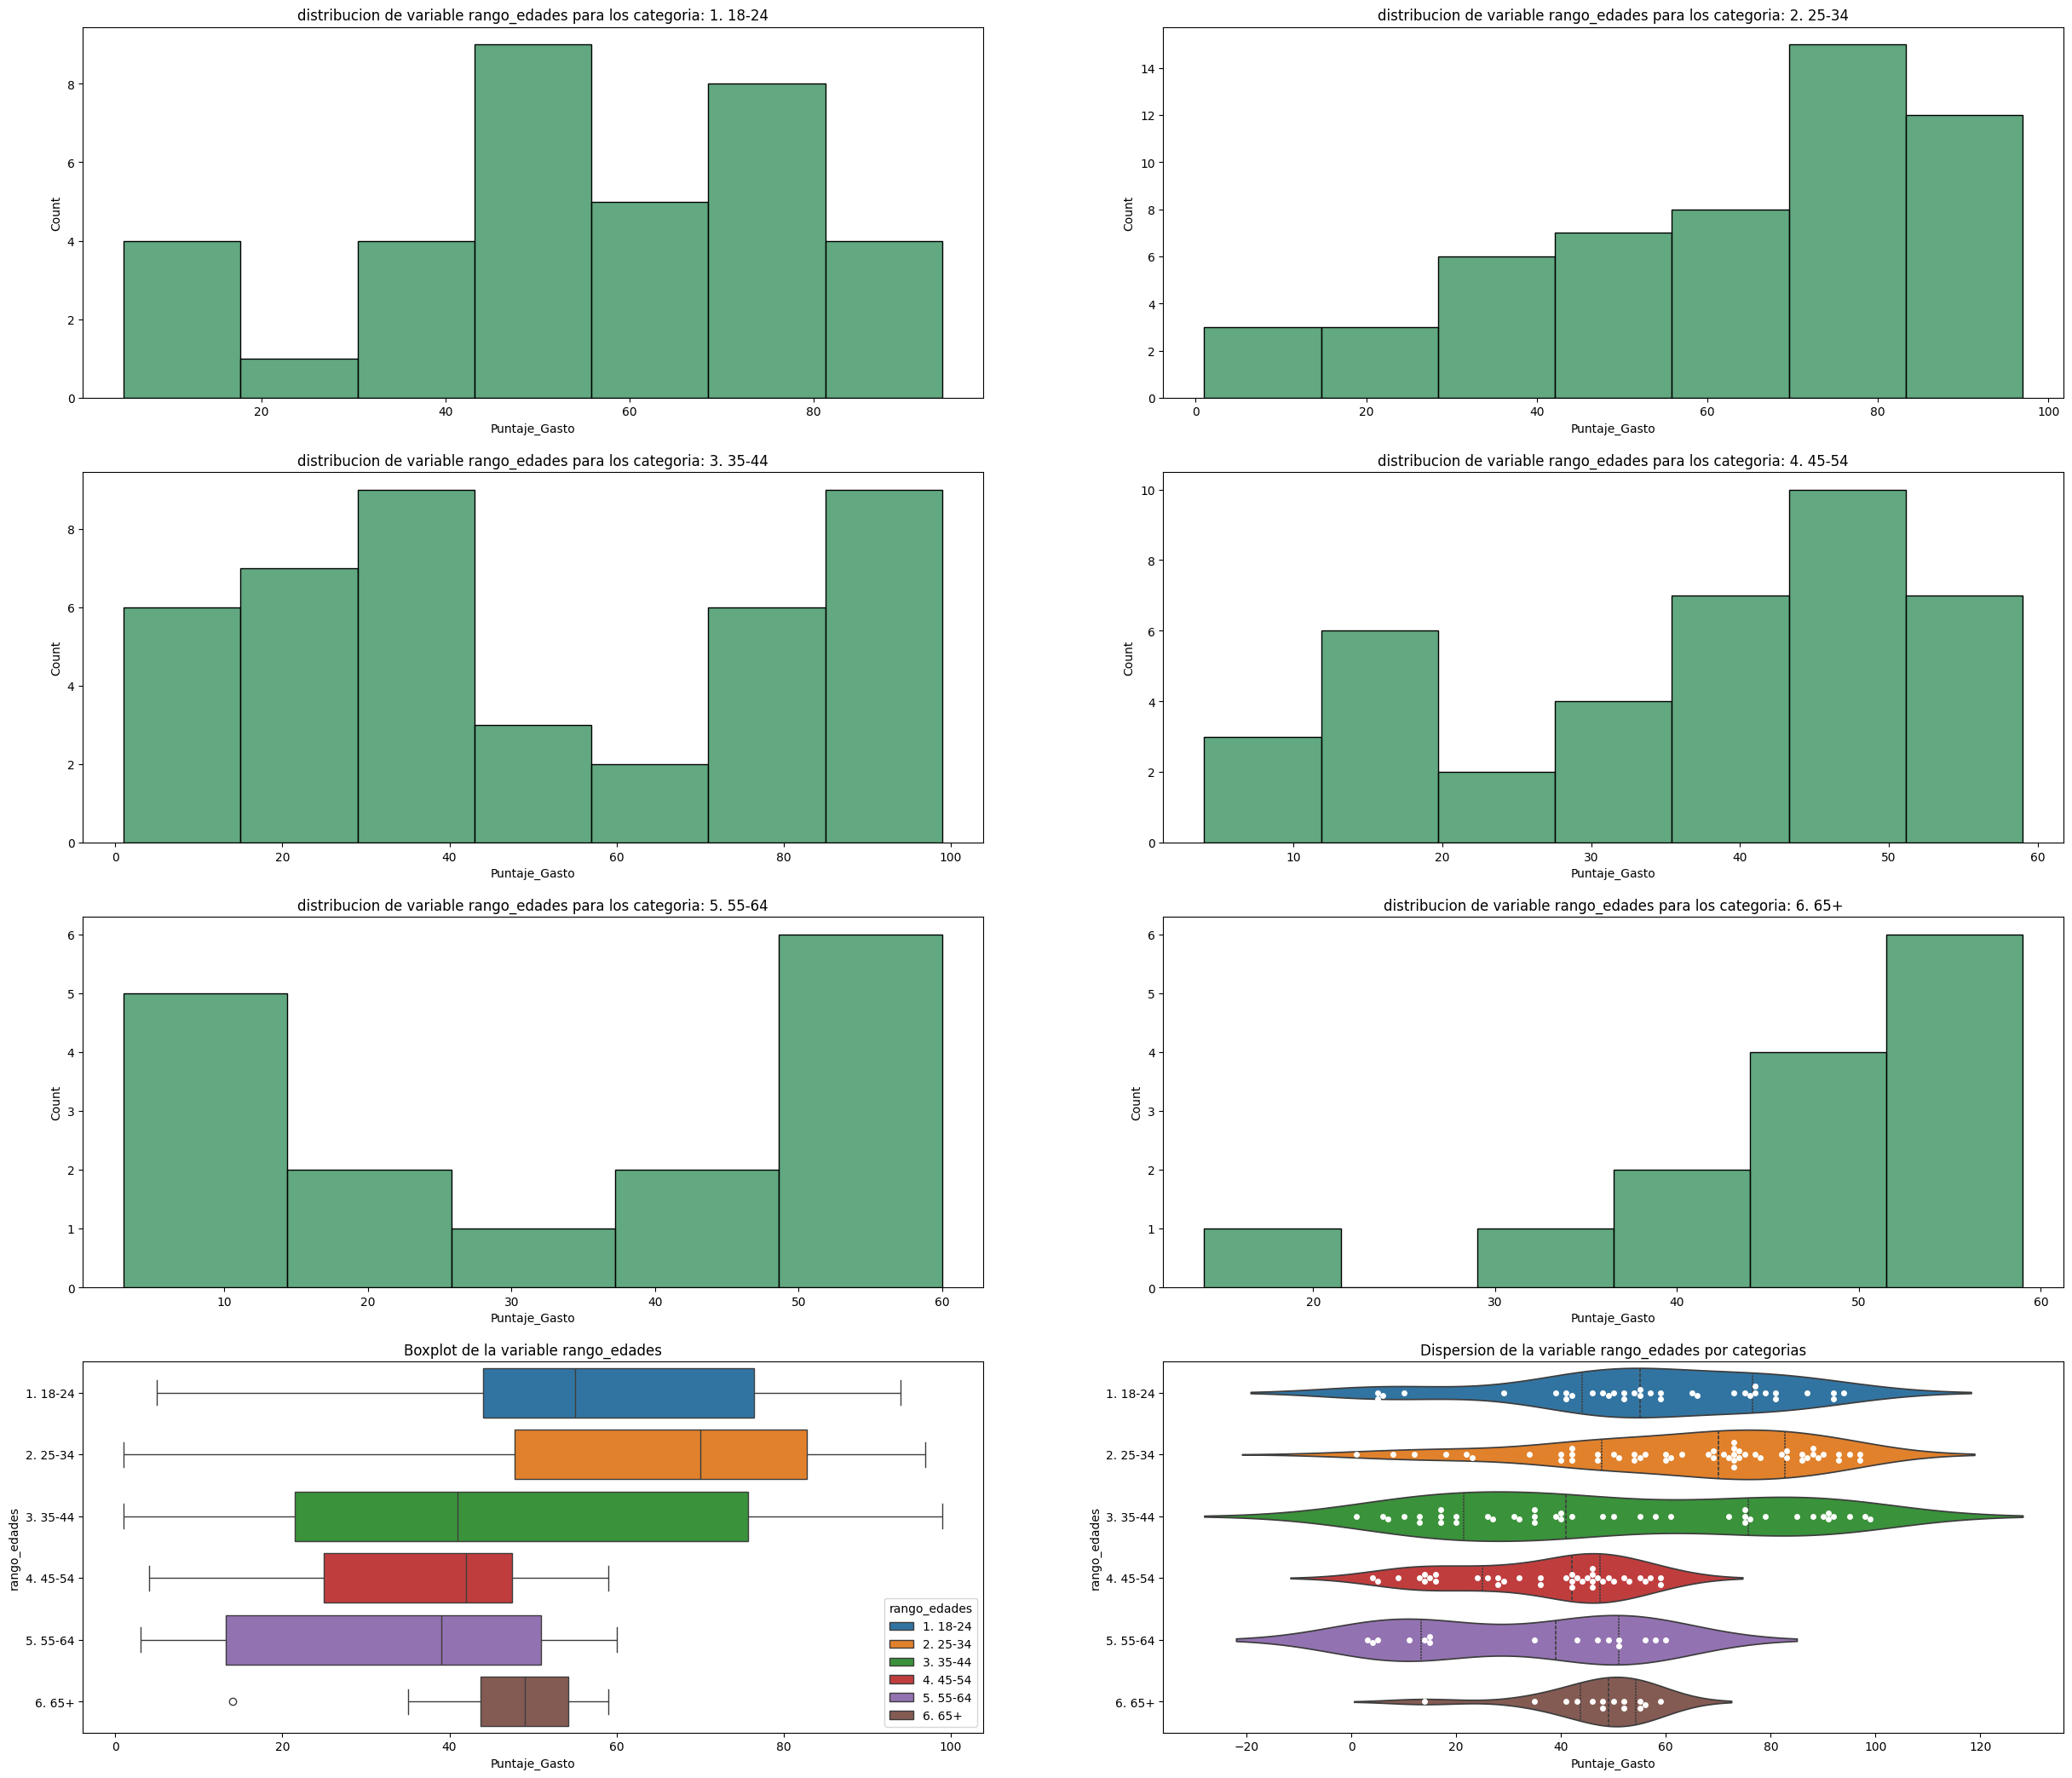

In [71]:
describe_variables(df_datos,"Puntaje_Gasto",grupo="rango_edades")

En el rango de edades vs puntaje de gastos vemos que llos de 25-34 son los que mas suelen gastar comprando con una media de 63 en puntaje

In [72]:
df_datos.columns

Index(['Id_Cliente', 'Genero', 'Edad', 'Ingreso', 'Puntaje_Gasto',
       'rango_edades'],
      dtype='object')

In [73]:
df_datos["edades_genero"] = df_datos["rango_edades"] + "-" + df_datos["Genero"]

Ingreso                                                    \
                  count          mean           std       min         25%   
edades_genero                                                               
1. 18-24-Hombre    16.0  46748.482500  21515.089905  13458.02  29984.6525   
1. 18-24-Mujer     19.0  42523.269474  19749.373173  15766.84  23830.8250   
2. 25-34-Hombre    22.0  78927.434545  32734.446993  22531.85  61793.4150   
2. 25-34-Mujer     32.0  65815.380000  23049.652497  19003.52  46428.2325   
3. 35-44-Hombre    18.0  67001.986111  22499.533107  18797.16  58063.7100   
3. 35-44-Mujer     24.0  66923.430000  31556.048353  19281.75  37553.3550   
4. 45-54-Hombre    14.0  58029.127143  20522.769162  24993.78  43724.2375   
4. 45-54-Mujer     25.0  59210.614800  26541.550152  24402.32  41739.8400   
5. 55-64-Hombre     9.0  55780.227778  25094.510046  18434.74  42262.0400   
5. 55-64-Mujer      7.0  57098.777143  20204.546850  19617.67  49946.0550   
6. 65+-Hombre       9.0  51366.806667  14577.260971  18437.21  45222.0600   
6. 65+-Mujer        5.0  51517.958000   9902.628197  37926.15  46970.5400   

                                                   
                       50%         75%        max  
edades_genero                                      
1. 18-24-Hombre  47652.490  60447.4525   80360.65  
1. 18-24-Mujer   38599.280  61699.1550   71427.64  
2. 25-34-Hombre  77390.985  96065.5225  138584.52  
2. 25-34-Mujer   72515.755  78621.0625  103654.79  
3. 35-44-Hombre  71638.860  83590.7100   91426.18  
3. 35-44-Mujer   72184.815  89797.3150  119534.68  
4. 45-54-Hombre  60761.560  69593.5850   97525.80  
4. 45-54-Mujer   54827.740  67219.4800  126685.78  
5. 55-64-Hombre  54475.760  71651.0800   94049.49  
5. 55-64-Mujer   58838.530  70389.0600   80565.01  
6. 65+-Hombre    52200.840  61969.1500   64156.37  
6. 65+-Mujer     50529.760  59872.0800   62291.26

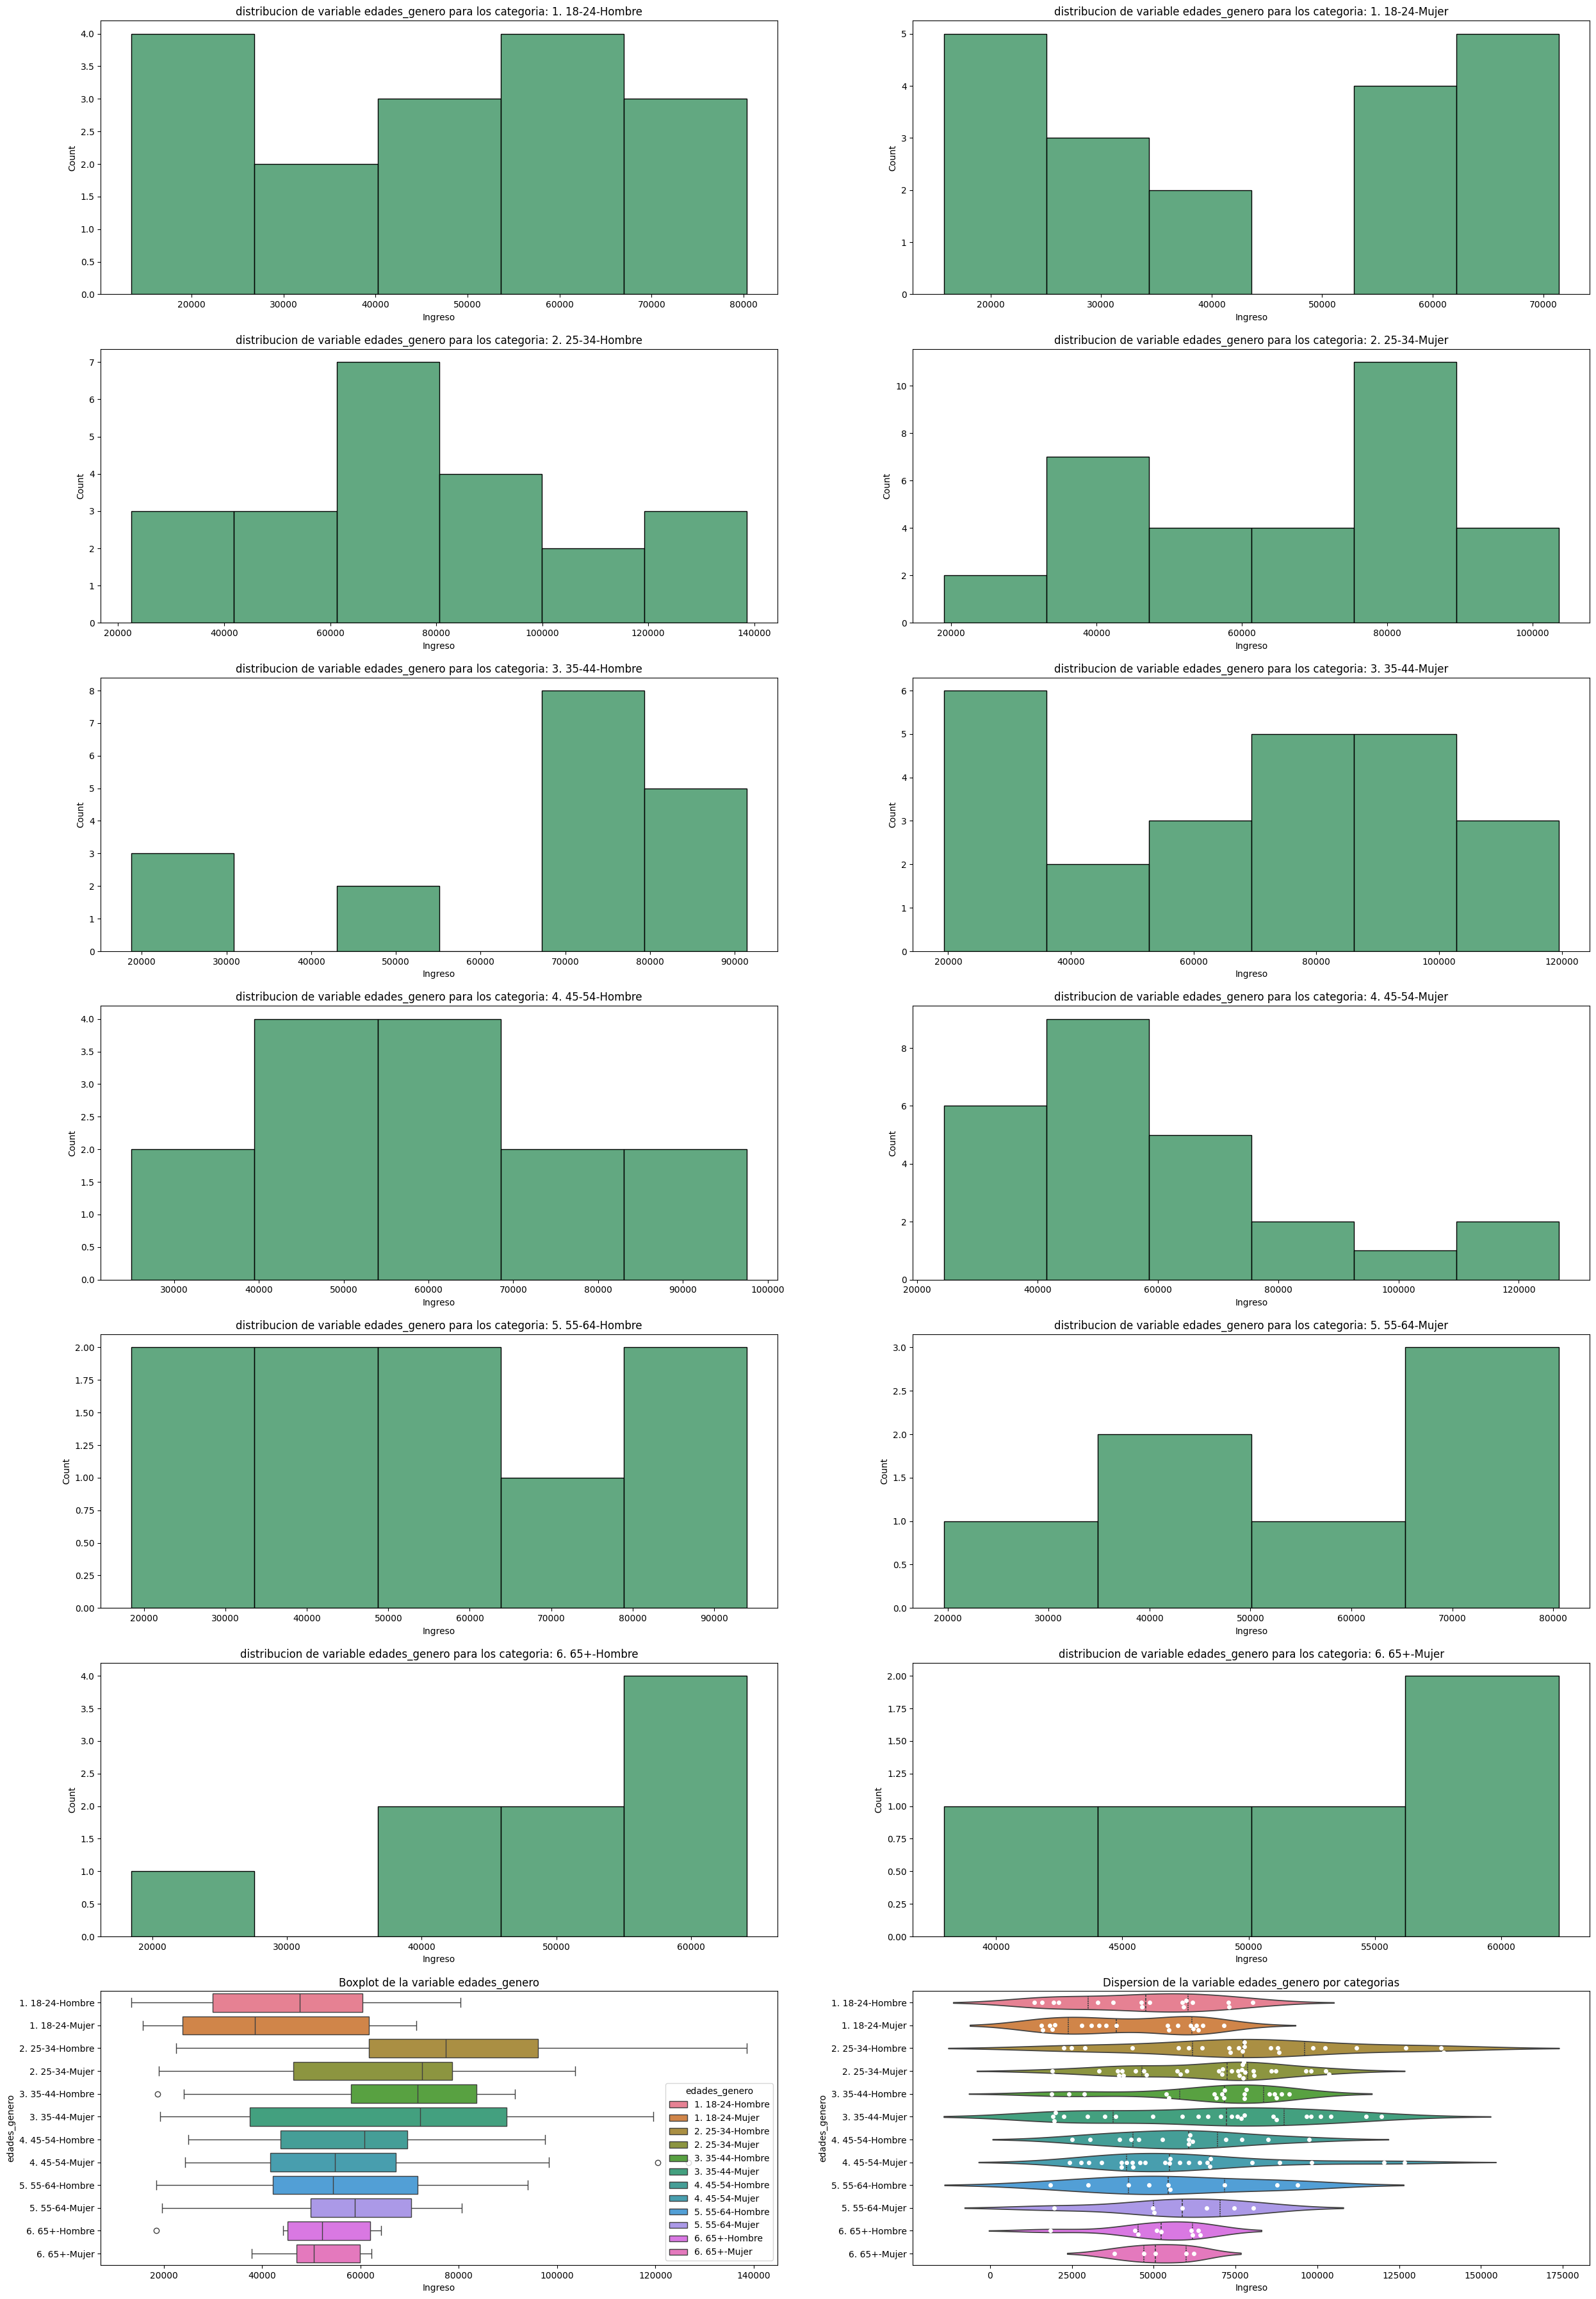

In [74]:
describe_variables(df_datos,variable="Ingreso", grupo="edades_genero")

Ahora se puede ver las edades y el genero y se encuentra que hombres entre 25-34 son aquellos con mayor ingreso promedio y las mujeres entre 18-24 las que tienen menor iungreso promedio.

Puntaje_Gasto                                                  \
                        count       mean        std   min    25%   50%    75%   
edades_genero                                                                   
1. 18-24-Hombre          16.0  51.875000  27.796583   5.0  40.50  53.5  69.25   
1. 18-24-Mujer           19.0  59.947368  21.754881   6.0  49.00  57.0  76.50   
2. 25-34-Hombre          22.0  62.454545  28.468407   1.0  55.25  71.0  80.25   
2. 25-34-Mujer           32.0  63.656250  21.413908  22.0  45.75  70.0  83.75   
3. 35-44-Hombre          18.0  50.777778  33.502512   1.0  17.75  51.5  84.75   
3. 35-44-Mujer           24.0  48.416667  29.120315   6.0  26.75  40.0  75.25   
4. 45-54-Hombre          14.0  34.357143  15.775381   4.0  26.75  38.5  46.00   
4. 45-54-Mujer           25.0  37.280000  16.754402   5.0  24.00  43.0  50.00   
5. 55-64-Hombre           9.0  28.444444  23.173860   3.0  11.00  15.0  51.00   
5. 55-64-Mujer            7.0  37.285714  20.385569   5.0  25.00  43.0  52.50   
6. 65+-Hombre             9.0  46.000000  13.453624  14.0  43.00  48.0  55.00   
6. 65+-Mujer              5.0  48.000000   7.713624  35.0  48.00  50.0  52.00   

                       
                  max  
edades_genero          
1. 18-24-Hombre  92.0  
1. 18-24-Mujer   94.0  
2. 25-34-Hombre  97.0  
2. 25-34-Mujer   95.0  
3. 35-44-Hombre  95.0  
3. 35-44-Mujer   99.0  
4. 45-54-Hombre  56.0  
4. 45-54-Mujer   59.0  
5. 55-64-Hombre  60.0  
5. 55-64-Mujer   58.0  
6. 65+-Hombre    59.0  
6. 65+-Mujer     55.0

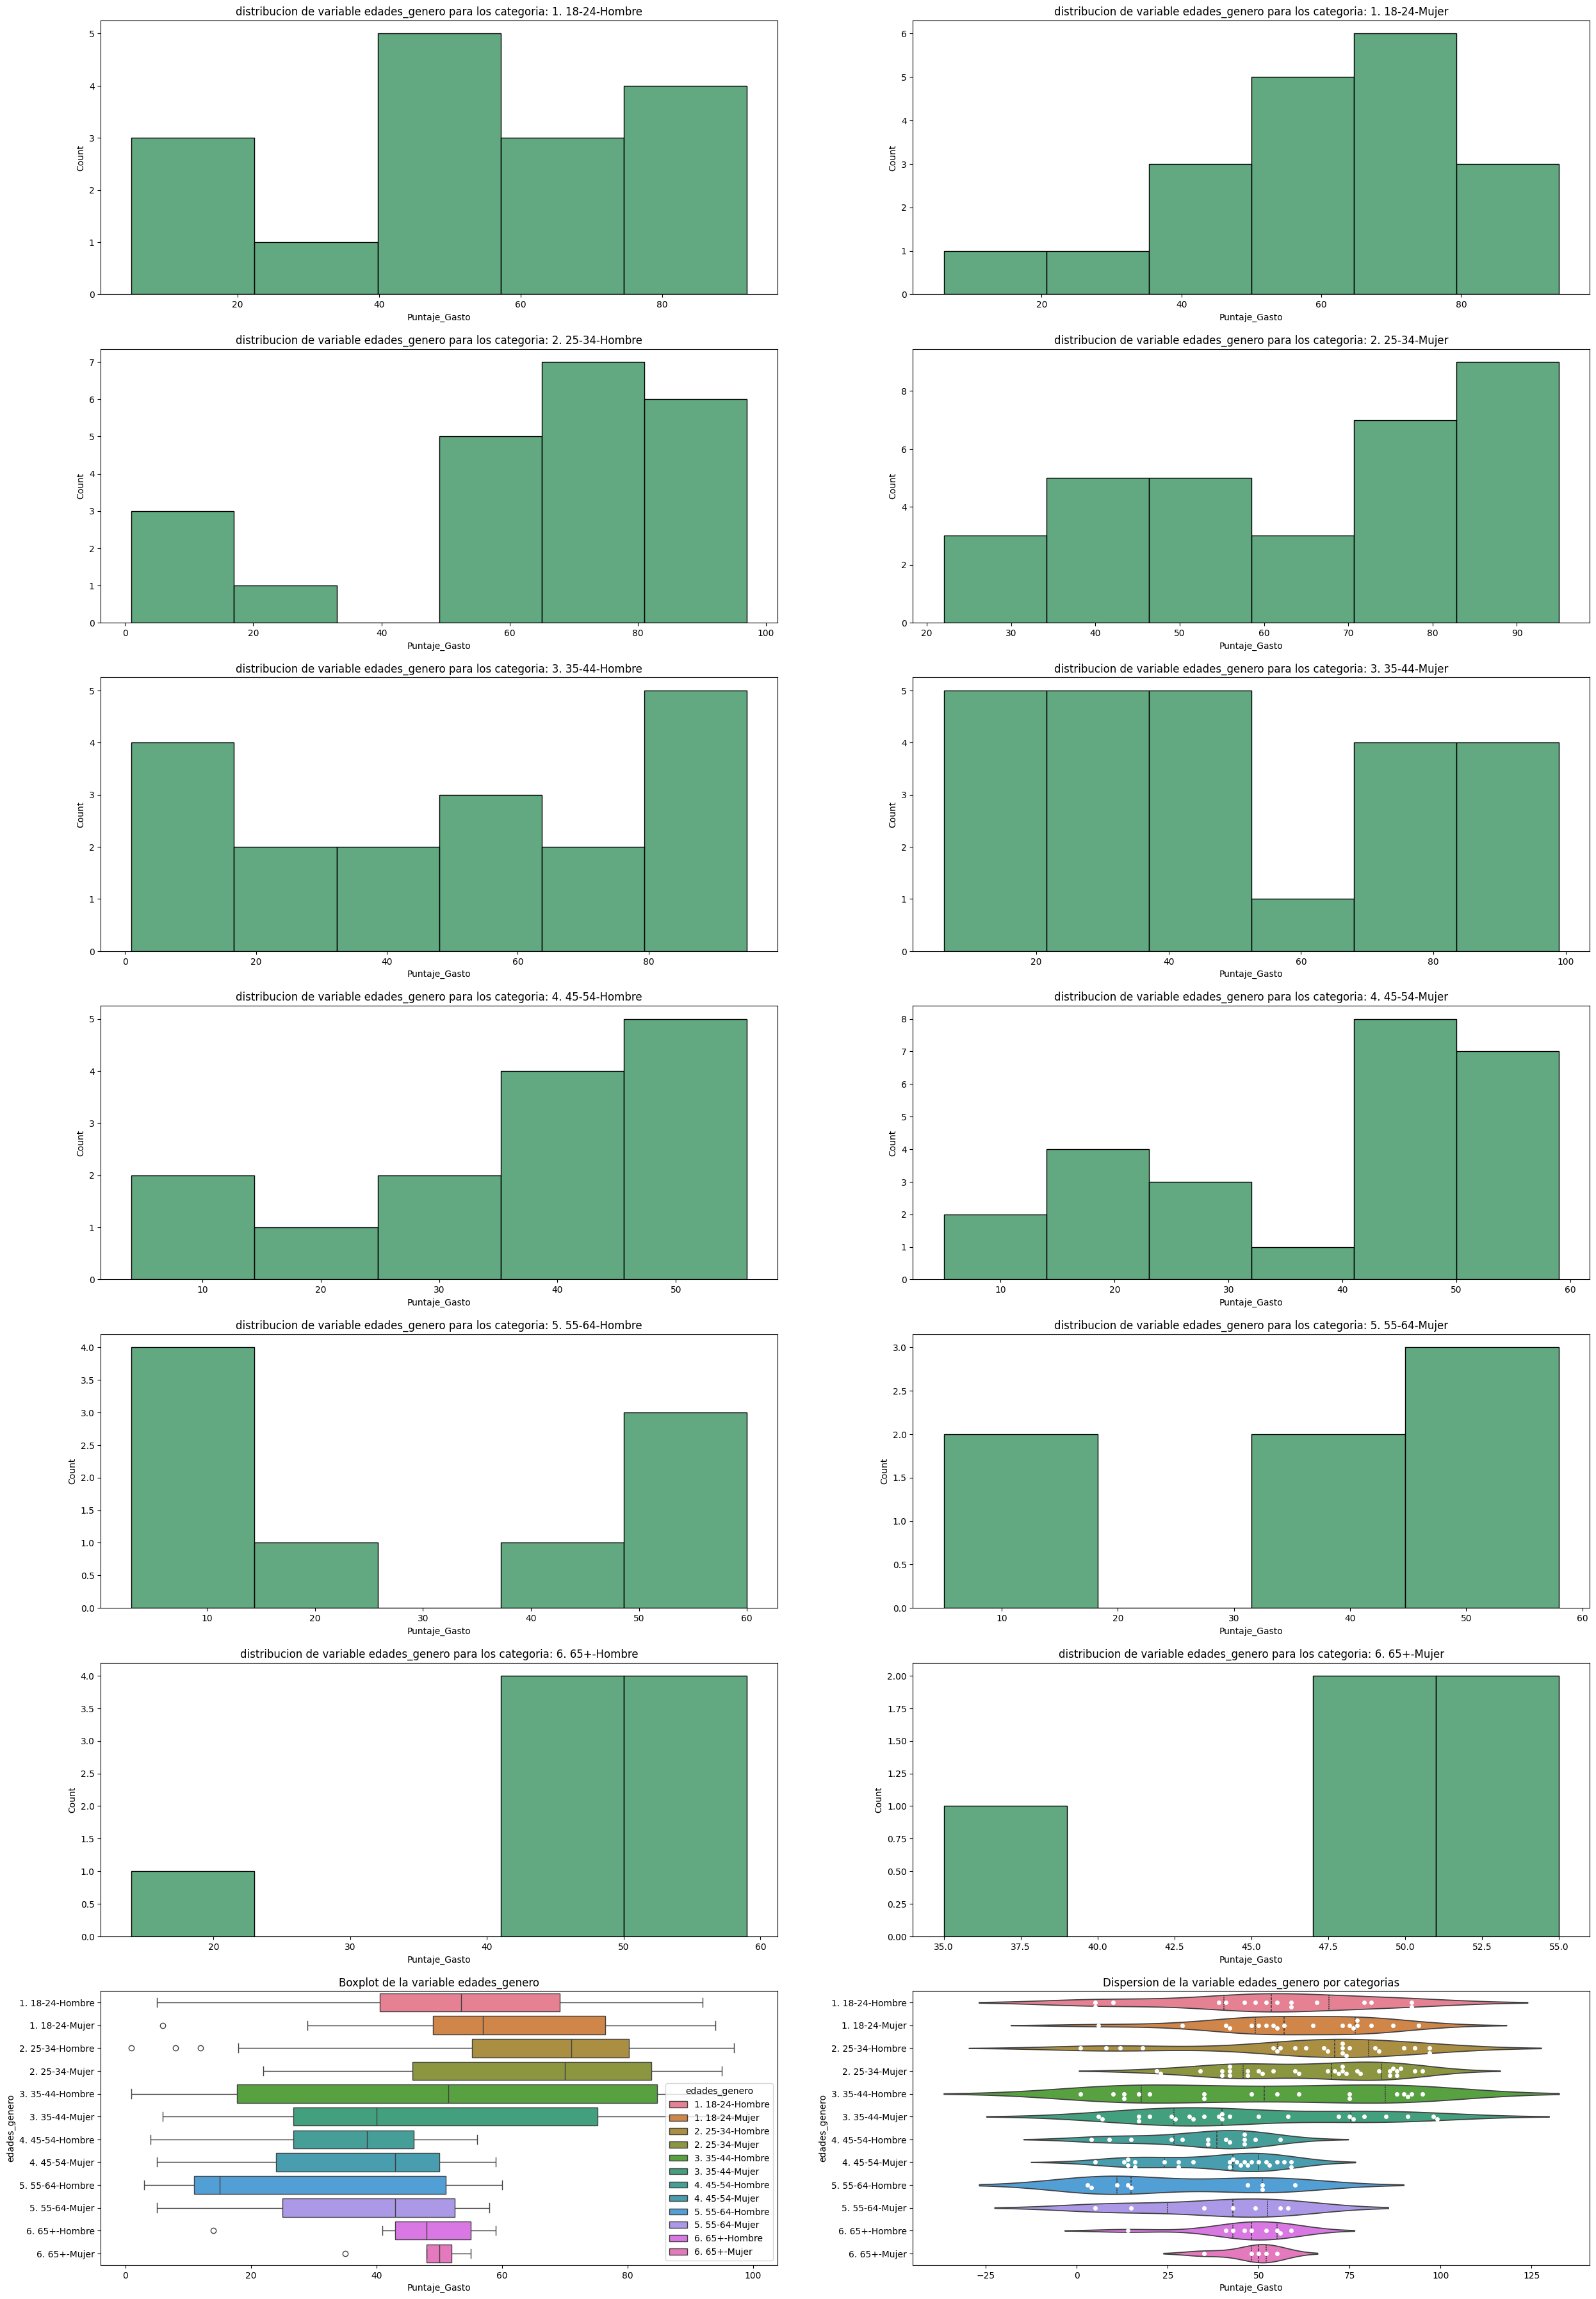

In [75]:
describe_variables(df_datos,"Puntaje_Gasto",grupo="edades_genero")

Viendo el puntaje de gasto, aunque las mujeres entre 18-24 tuvieran el menos ingreso tienen un puntaje de gasto mayor que los hombres de ese mismo rango de edad. Pero al igual que en el ingreso, los hombres de 25-34 tienen un promedio de puntaje de gasto mas alto

<Axes: xlabel='Ingreso', ylabel='Puntaje_Gasto'>

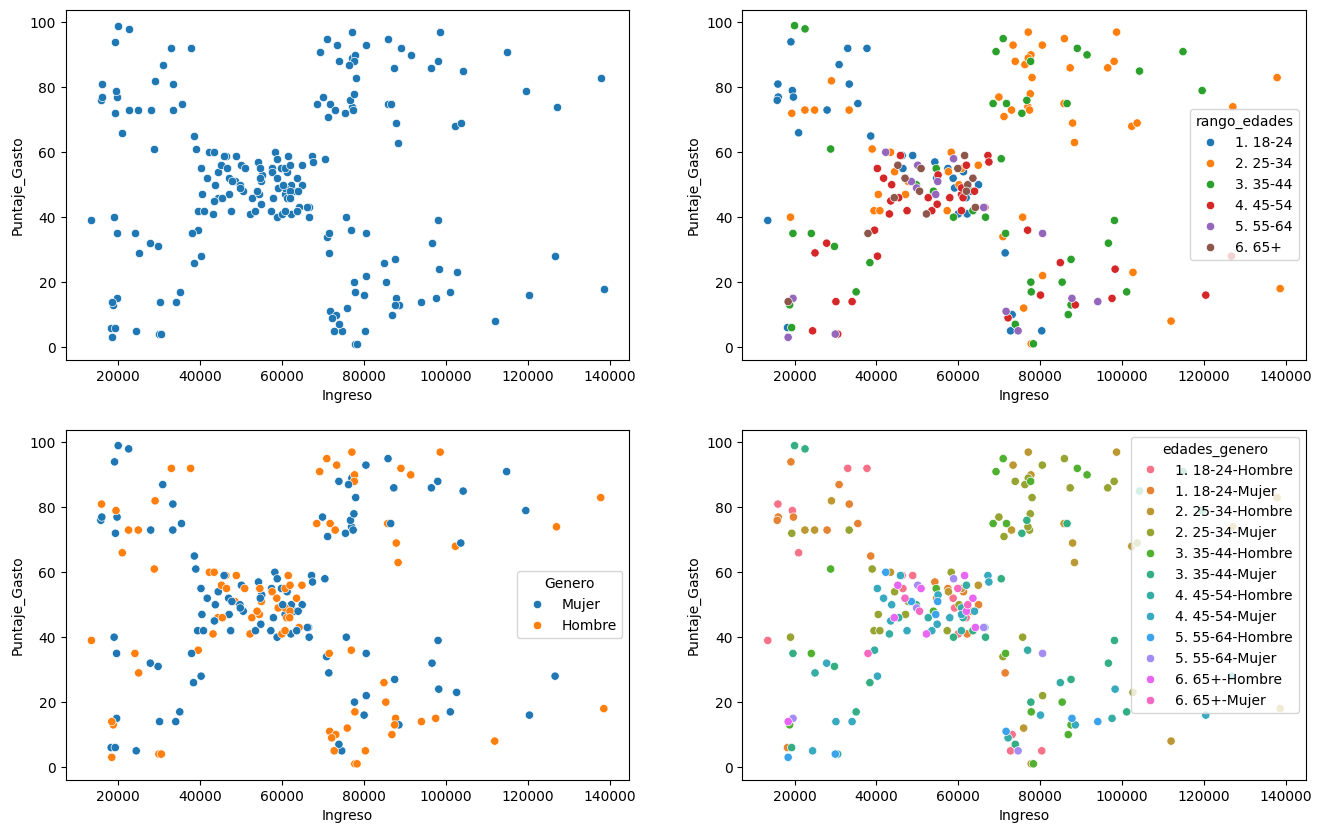

In [76]:
n_rows = 2
n_cols = 2

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*8, n_rows*5))
axs = ax.flatten()

sns.scatterplot(data=df_datos, x="Ingreso",y="Puntaje_Gasto",ax=axs[0])
sns.scatterplot(data=df_datos.sort_values(by="rango_edades"), x="Ingreso",y="Puntaje_Gasto",hue="rango_edades",ax=axs[1])
sns.scatterplot(data=df_datos, x="Ingreso",y="Puntaje_Gasto",hue="Genero",ax=axs[2])
sns.scatterplot(data=df_datos.sort_values("edades_genero"), x="Ingreso",y="Puntaje_Gasto",hue="edades_genero",ax=axs[3])

Podemos ver las variables de puntaje de gasto vs otras variables y definir clusters de las observaciones, a primera vista sin ningun analisis matematico, vemos al menors 5 clusters importantes, Dos arriba, dos abajo y uno en el medio, aunque esto solo es al ojo, habra que hacer un mejor analisis para determinar la realidad

### 3. Clustering Jerárquico

#### 3.1. Dendrogramas

Agrupe a los clientes utilizando sólo dos variables: su ingreso y el puntaje de gastos. Para ello retenga estas dos variables, estandarízelas, construya y grafique un dendograma. Para la construcción del dendrograma utilice el enlace 'ward' y la distancia euclidiana. Explique la importancia de estandarizar los datos.

In [77]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from sklearn.preprocessing import StandardScaler

In [78]:
df_datos[["Ingreso","Puntaje_Gasto"]]

,Ingreso,Puntaje_Gasto
0,98115.05,39
1,35458.14,75
2,59872.08,55
3,48508.93,51
4,44431.11,54
...,...,...
195,19322.17,72
196,43486.37,45
197,24086.95,35
198,38599.28,65


In [79]:
# Utilice este espacio para escribir el código.
scaler = StandardScaler()
df_datos_scaled = pd.DataFrame(scaler.fit_transform(df_datos[["Ingreso","Puntaje_Gasto"]]))

df_datos_scaled.describe()
# dist = pdist(X, metric='euclidean')
# Z = linkage(dist, method='ward')

,0,1
count,2.000000e+02,2.000000e+02
mean,-1.243450e-16,-1.021405e-16
std,1.002509e+00,1.002509e+00
min,-1.800440e+00,-1.910021e+00
25%,-7.295316e-01,-5.997931e-01
50%,5.859924e-03,-7.764312e-03
75%,6.305804e-01,8.851316e-01
max,2.975897e+00,1.894492e+00


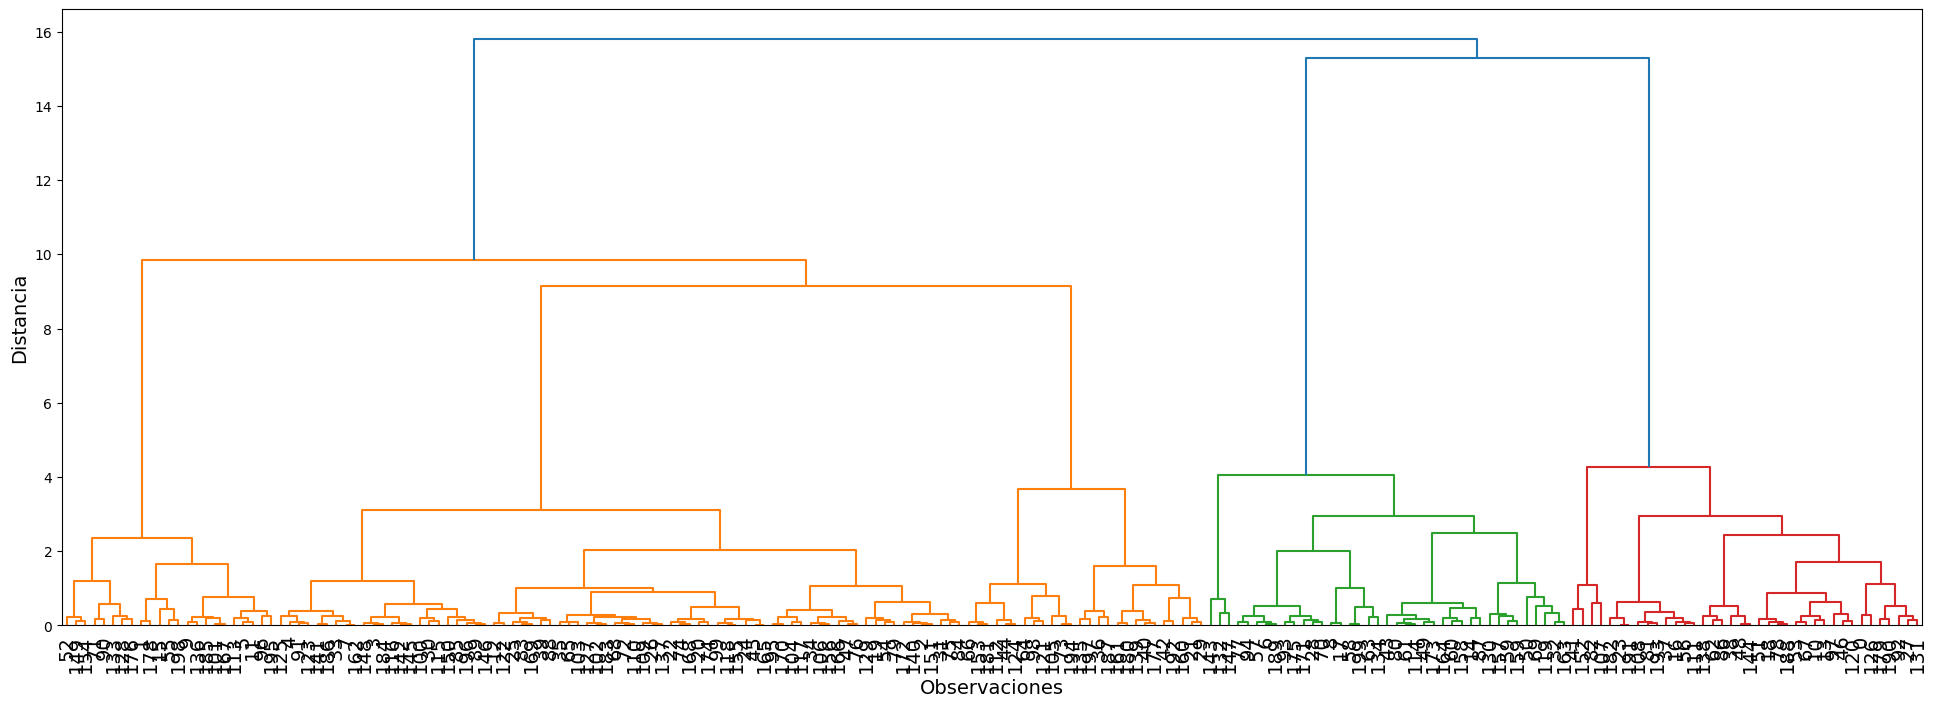

In [80]:
from scipy.cluster.hierarchy import dendrogram

dist = pdist(df_datos_scaled, metric='euclidean')
Z = linkage(dist, method='ward')

fig, ax = plt.subplots(figsize=(24, 8))
d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax)
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_ylabel('Distancia', fontsize=14)
plt.show()

Se puede ver entonces como se separan los clusters y a que distancias se juntan estos, gracias al dendograma. A continuacion determinaremos cuantos clusters tomar:

#### 3.2. Número de clusters

Retenga el número de clusters que se obtengan luego de fijar la distancia en 6.

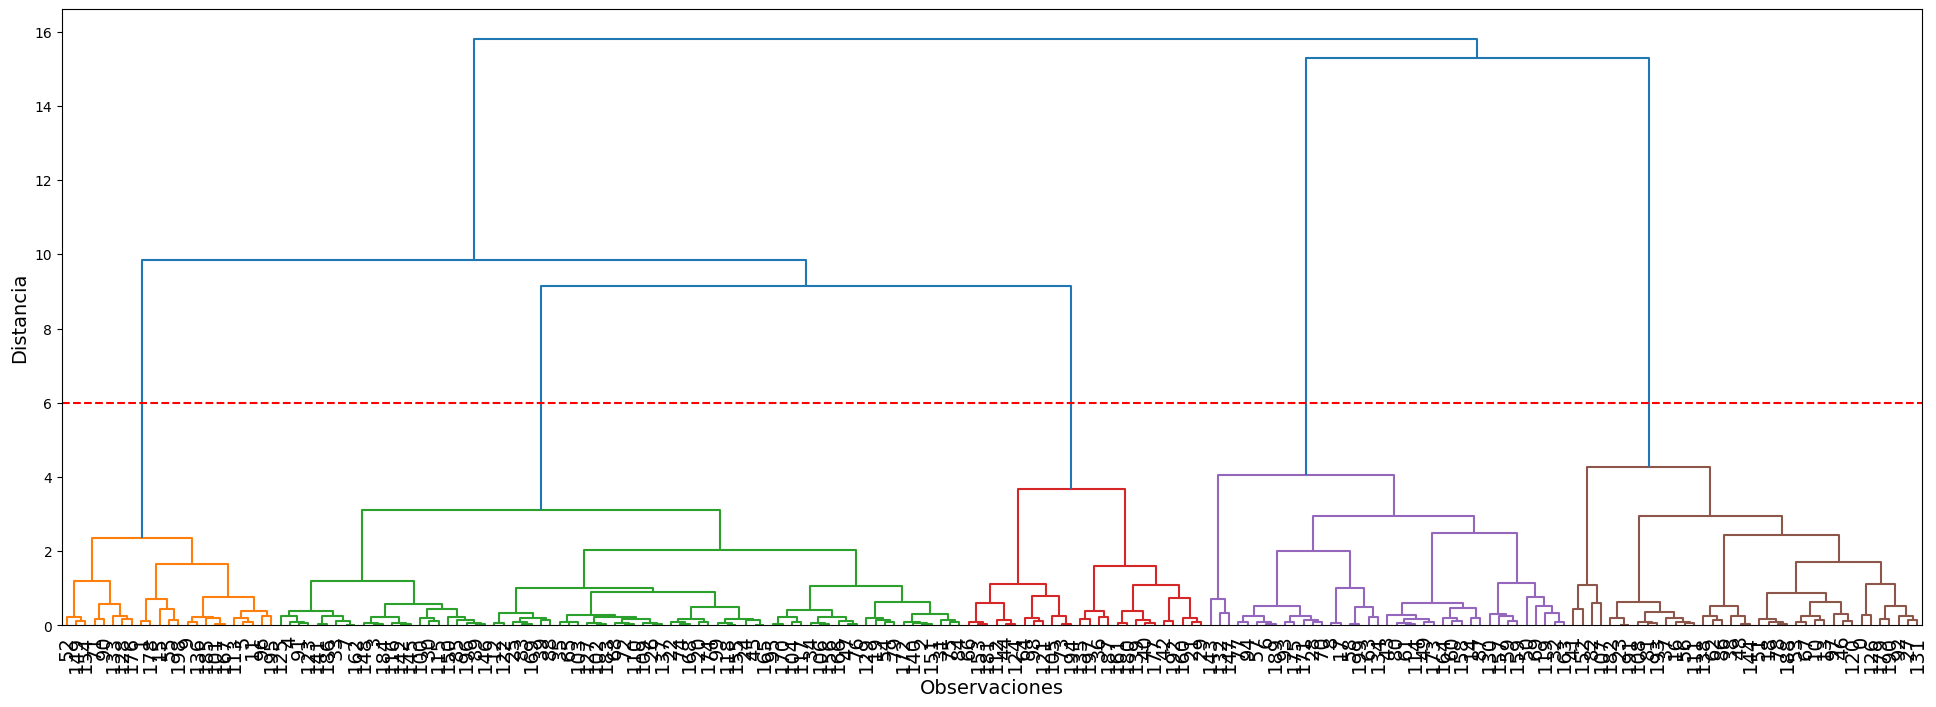

In [81]:
distancia = 6

fig, ax = plt.subplots(figsize=(24, 8))
d = dendrogram(Z, show_leaf_counts=True, leaf_font_size=14, ax=ax,color_threshold=distancia)
ax.axhline(y=distancia, color='r', linestyle='--', label="Distnacia fija en = {d}".format(d=distancia))
ax.set_xlabel('Observaciones', fontsize=14)
ax.set_ylabel('Distancia', fontsize=14)
plt.show()

Al dejar distancia en 6, leyendo el dendograma vemos que se toman 5 clusters, que son los que se vieron inicialmente solo al ojo

#### 3.3. Algoritmo Jerárquico Aglomerativo

Utilizando el número de clusters encontrados en el paso anterior, aplique el algoritmo jerárquico aglomerativo, utilizando el enlace 'ward' y la distancia euclidiana. Describa los grupos encontrados, en que grupo o grupos concentraría su estrategia de marketing y por qué?

In [82]:
# Utilice este espacio para escribir el código.
from sklearn.cluster import AgglomerativeClustering

cluster_AggC = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')

cluster_sk = cluster_AggC.fit_predict(df_datos_scaled)


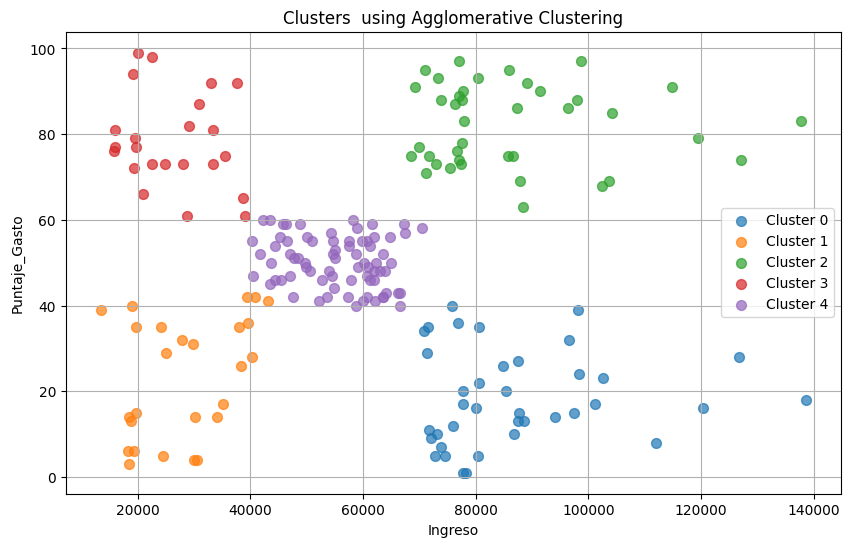

In [83]:
def plot_clusters_aggc(df, cluster_labels):
    plt.figure(figsize=(10, 6))
    unique_clusters = np.unique(cluster_labels)
    for cluster in unique_clusters:
        plt.scatter(
            df.loc[cluster_labels == cluster, 'Ingreso'],
            df.loc[cluster_labels == cluster, 'Puntaje_Gasto'],
            label=f'Cluster {cluster}',
            s=50, alpha=0.7
        )
    plt.title('Clusters  using Agglomerative Clustering')
    plt.xlabel('Ingreso')
    plt.ylabel('Puntaje_Gasto')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_clusters_aggc(df_datos, cluster_sk)

Se puede ver entonces que usando 5 clusters (encontrados gracias a una distancia de 6) se divide como lo vimos inicialmente al ojo en 5 clusters. Lo que nos puede decir que estos grupos de personas se pueden clasificar por ingresoso y puntaje de gasto en 5 grupos diferentes.

##### Donde enfocar el marketing
Enfocaria una estrategia de marketing en los clusters 0 y 4:

* En el cluster 0 tienen un alto ingreso pero bajo puntaje de gasto, por lo que tienen los medios para comprar pero no hacen tantas compras, si enfocamos una campaña de marketing a este grupo podriamos hacer que el puntaje de gasto aumente.

* El cluster 4 aunque con menores ingresos que el cluster 0 tiene mejor puntaje de gasto, y seria posible hacer que aprovechando su capacidad monetaria aumenten aun mas su puntaje de gasto parecido a los clusters 2 y 3.


Los demas clusters no valdria la pena utilizar recursos en ellos, pues por ejemplo los cluster 2 y 3 ya tienen un puntaje de gasto alto, y el cluster 1 pueden no tener los medios para subir mucho mas el puntaje de gasto (aunque podria ser posible buscar de que forma hacer que suban al cluster 3, pero puede ser mas dificil solo con marketing) 

### 4. DBSCAN

Implemente DBSCAN, al igual que el punto anterior sólo dos variables: su ingreso y el puntaje de gastos. Al implementar  justifique su elección de `min_samples` y `eps`. ¿Cuántos grupos o clusters encuentra? ¿Cuáles son su características? ¿Cambiaría su estrategia de marketing respecto al punto anterior? Justifique su respuesta.

In [84]:
# Utilice este espacio para escribir el código.

X=df_datos_scaled


#### Eleccion `eps`

In [85]:

from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

def find_knee_points(data, n_neighbors_list, metric='minkowski'):
    knee_values = []
    
    # Definir una lista de colores usando la paleta "tab10"
    colors = plt.cm.tab10(np.linspace(0, 1, len(n_neighbors_list)))
    
    plt.figure(figsize=(10, 6), dpi=100)
    
    for idx, n in enumerate(n_neighbors_list):
        # Crear el modelo de vecinos más cercanos
        neigh = NearestNeighbors(n_neighbors=n, metric=metric)
        nbrs = neigh.fit(data)
        distancias, indices = nbrs.kneighbors(data)
        distancias = np.sort(distancias.flatten())
        
        # Calculo de rodilla
        i = np.arange(len(distancias))
        knee_locator = KneeLocator(i, distancias, curve='convex', direction='increasing')
        
        # Verificar si se encontró un punto de rodilla
        if knee_locator.elbow is not None:
            knee_value = distancias[knee_locator.elbow]
        else:
            knee_value = np.nan  # En caso de que no se encuentre un punto de rodilla
        
        knee_values.append(knee_value)
        
        # Obtener un color para la línea
        color = colors[idx]
        
        plt.plot(distancias, label=f'n_neighbors = {n}', color=color)
        if not np.isnan(knee_value):
            plt.axhline(y=knee_value, color=color, linestyle='--', label=f'Knee at {n} = {knee_value:.2f}')

    plt.xlabel('Data Points')
    plt.ylabel('Distance')
    plt.title('Knee Point Analysis for Different n_neighbors')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    return knee_values

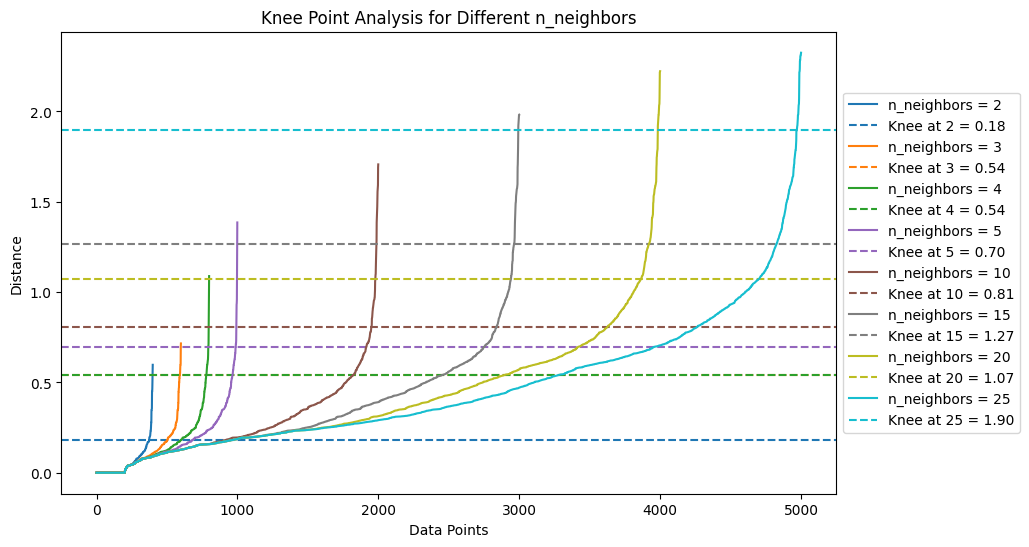

Puntos de rodilla encontrados para diferentes numeros de vecinos:
    n_neighbors   epsilon
0            2  0.179404
1            3  0.541554
2            4  0.541554
3            5  0.697700
4           10  0.807265
5           15  1.268784
6           20  1.073379
7           25  1.895446


In [86]:
n_neighbors_list = [2, 3, 4, 5, 10, 15, 20, 25]  
epsilon_list = find_knee_points(X, n_neighbors_list)

neighbors_epsilon=pd.DataFrame({'n_neighbors':n_neighbors_list, 'epsilon':epsilon_list})

print('Puntos de rodilla encontrados para diferentes numeros de vecinos:\n', neighbors_epsilon)

Observando lo knees, se encuentra que a diferentes numeros de n_neighbors hay diferentes eps, si tomamos un promedio dice que deberia ser tomar eps cerca de 0.5. Sin embargo viendo mas adelante la eleccion de min_samples calculando con diferentes eps se encuentra que usando eps cerca a 0.35-0.4 se encunetran mejores resultados

#### Eleccion `min_samples` y mejores `eps`

Para elegir este parámetro sin embargo no existe un método, la elección depende del conocimiento y experiencia de quien implementa el algoritmo. Sin embargo vamos a ver algunos datos, empezando desde min_samples=4.  `min_samples` debe aumentar con la dimensionalidad de los datos. Para datos con dos dimensiones, se puede utilizar el valor de `min_samples=4` sugerido por Ester et al. (1996). Por esta razon empezamos desde aca y veremos como se comporta

In [87]:
def plot_dbscan_across_epsilons(data, epsilon_list, min_samples_list):
    fig, axes = plt.subplots(len(epsilon_list), len(min_samples_list), figsize=(15, len(epsilon_list) * 5), dpi=100)
    
    for i, e in enumerate(epsilon_list):        
        for j, n in enumerate(min_samples_list):
            # Apply DBSCAN with the current epsilon and min_samples
            db = DBSCAN(eps=e, min_samples=n).fit(data)
            cluster_labels = db.labels_
            n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
            
            # Assign clusters to the dataframe
            resultado = pd.DataFrame(data).assign(Cluster=cluster_labels)
            
            # Plot the clusters
            ax = axes[i, j] if len(epsilon_list) > 1 else axes[j]
            for k in np.unique(cluster_labels):
                if k != -1:
                    ax.scatter(
                        x=resultado.loc[resultado.Cluster == k, 0], 
                        y=resultado.loc[resultado.Cluster == k, 1]
                    )
                else:
                    ax.scatter(
                        x=resultado.loc[resultado.Cluster == k, 0], 
                        y=resultado.loc[resultado.Cluster == k, 1],
                        c="black"
                    )
            ax.set_title(f'eps = {e:.2f}: {n_clusters} clusters, min_samples={n}')
            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
    
    plt.tight_layout()
    plt.show()

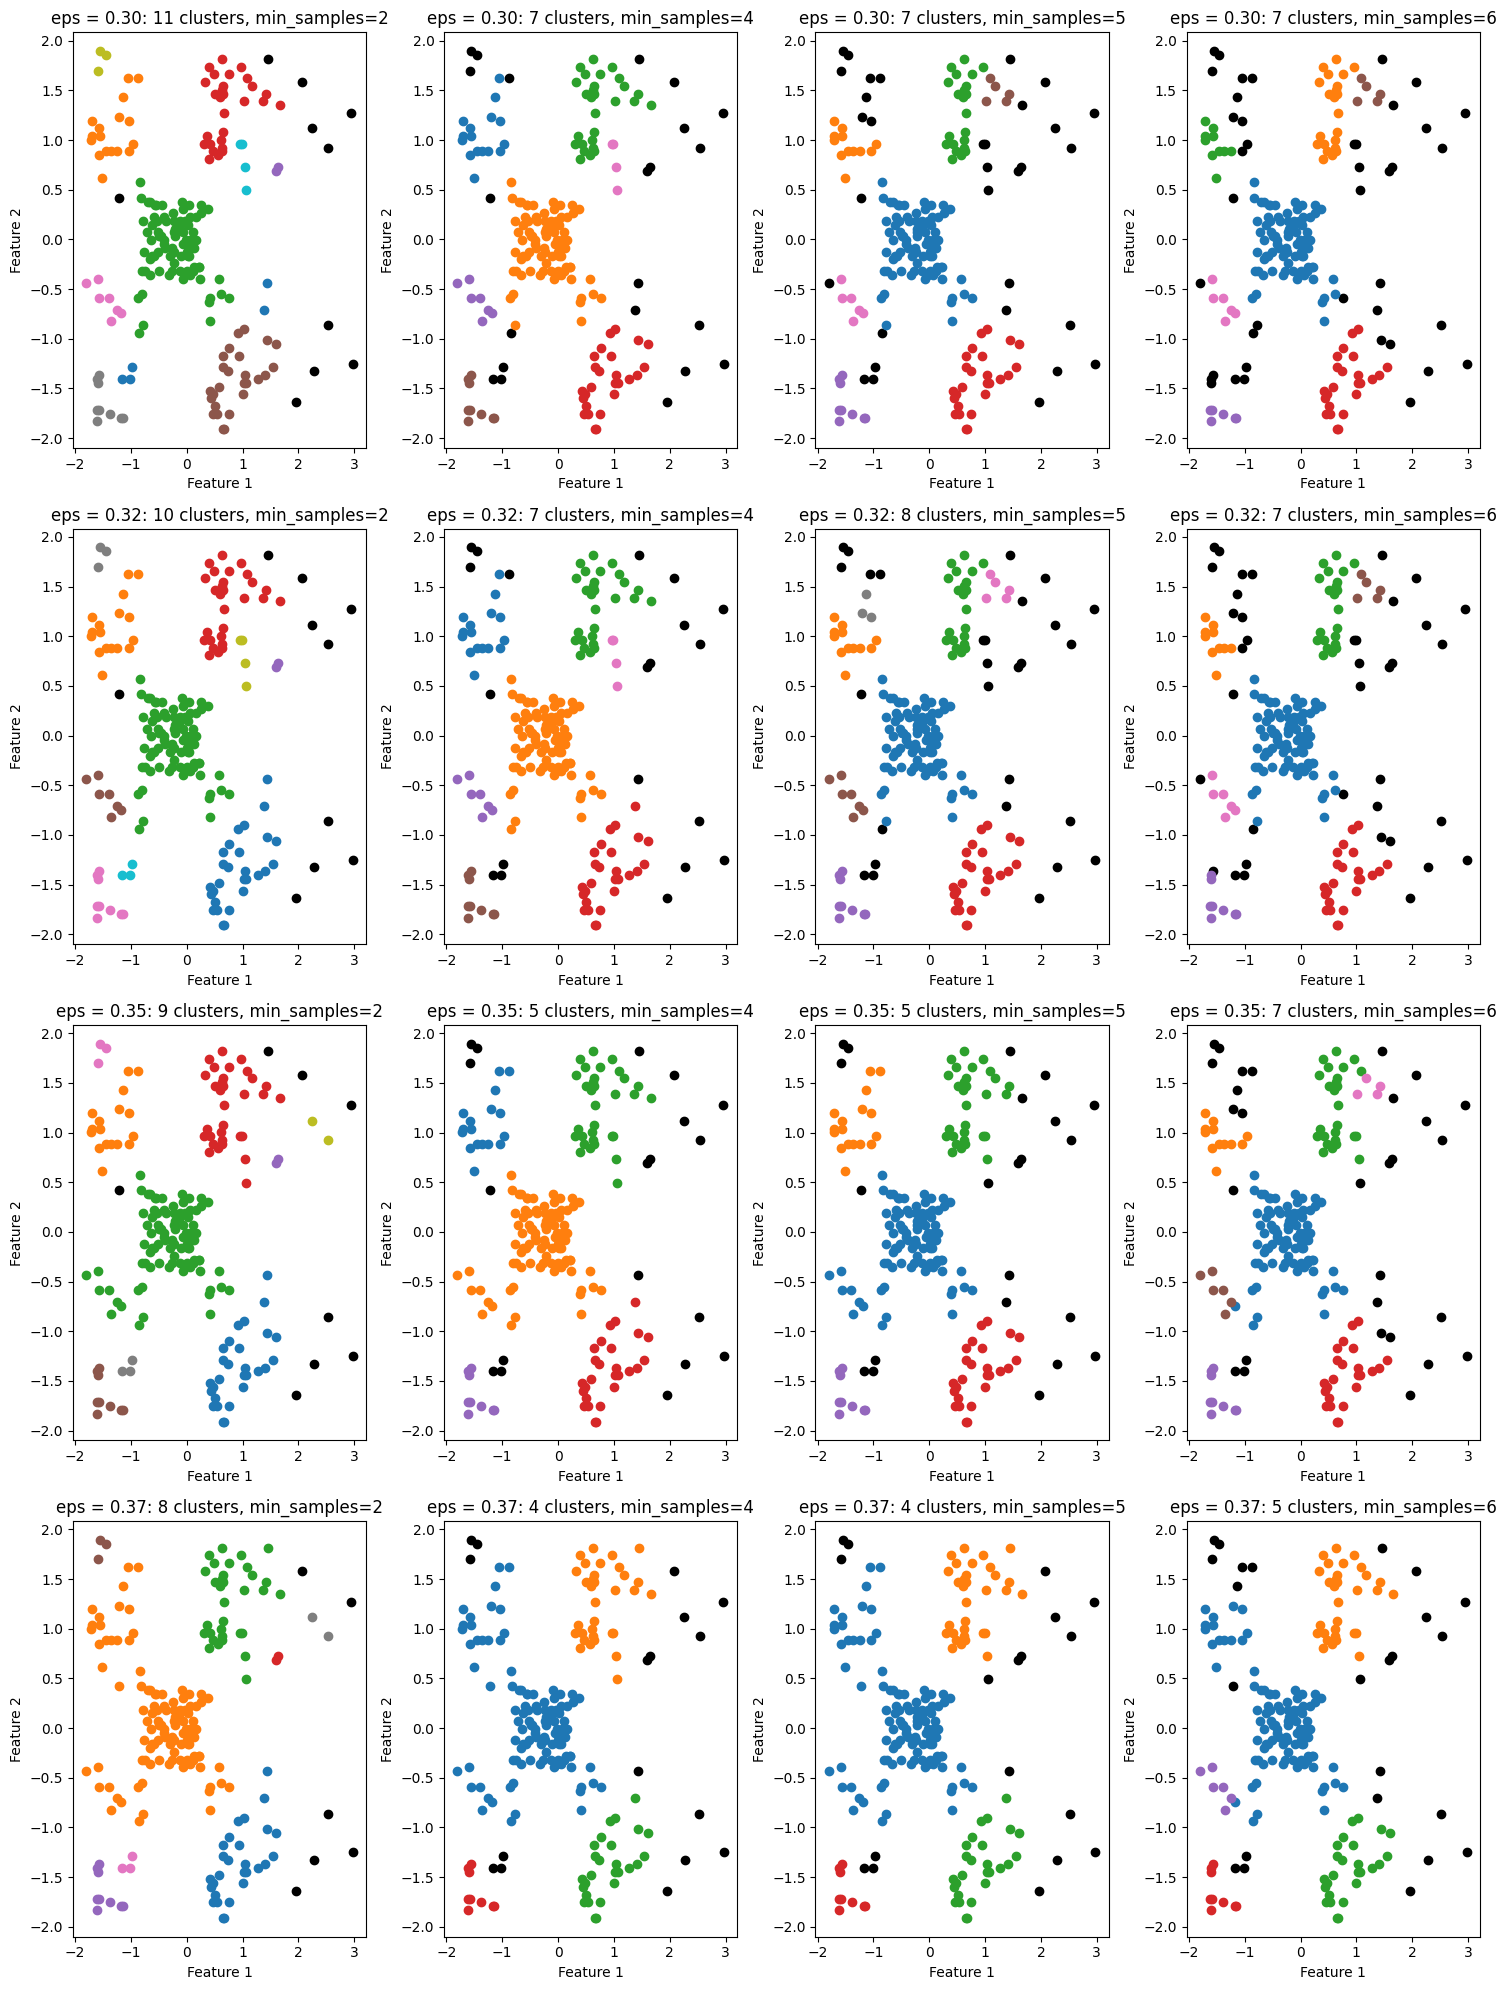

In [88]:
epsilon_list = [0.3 , 0.32 ,0.35, 0.37] 
min_samples_list = [2, 4, 5, 6]  
plot_dbscan_across_epsilons(X, epsilon_list, min_samples_list)

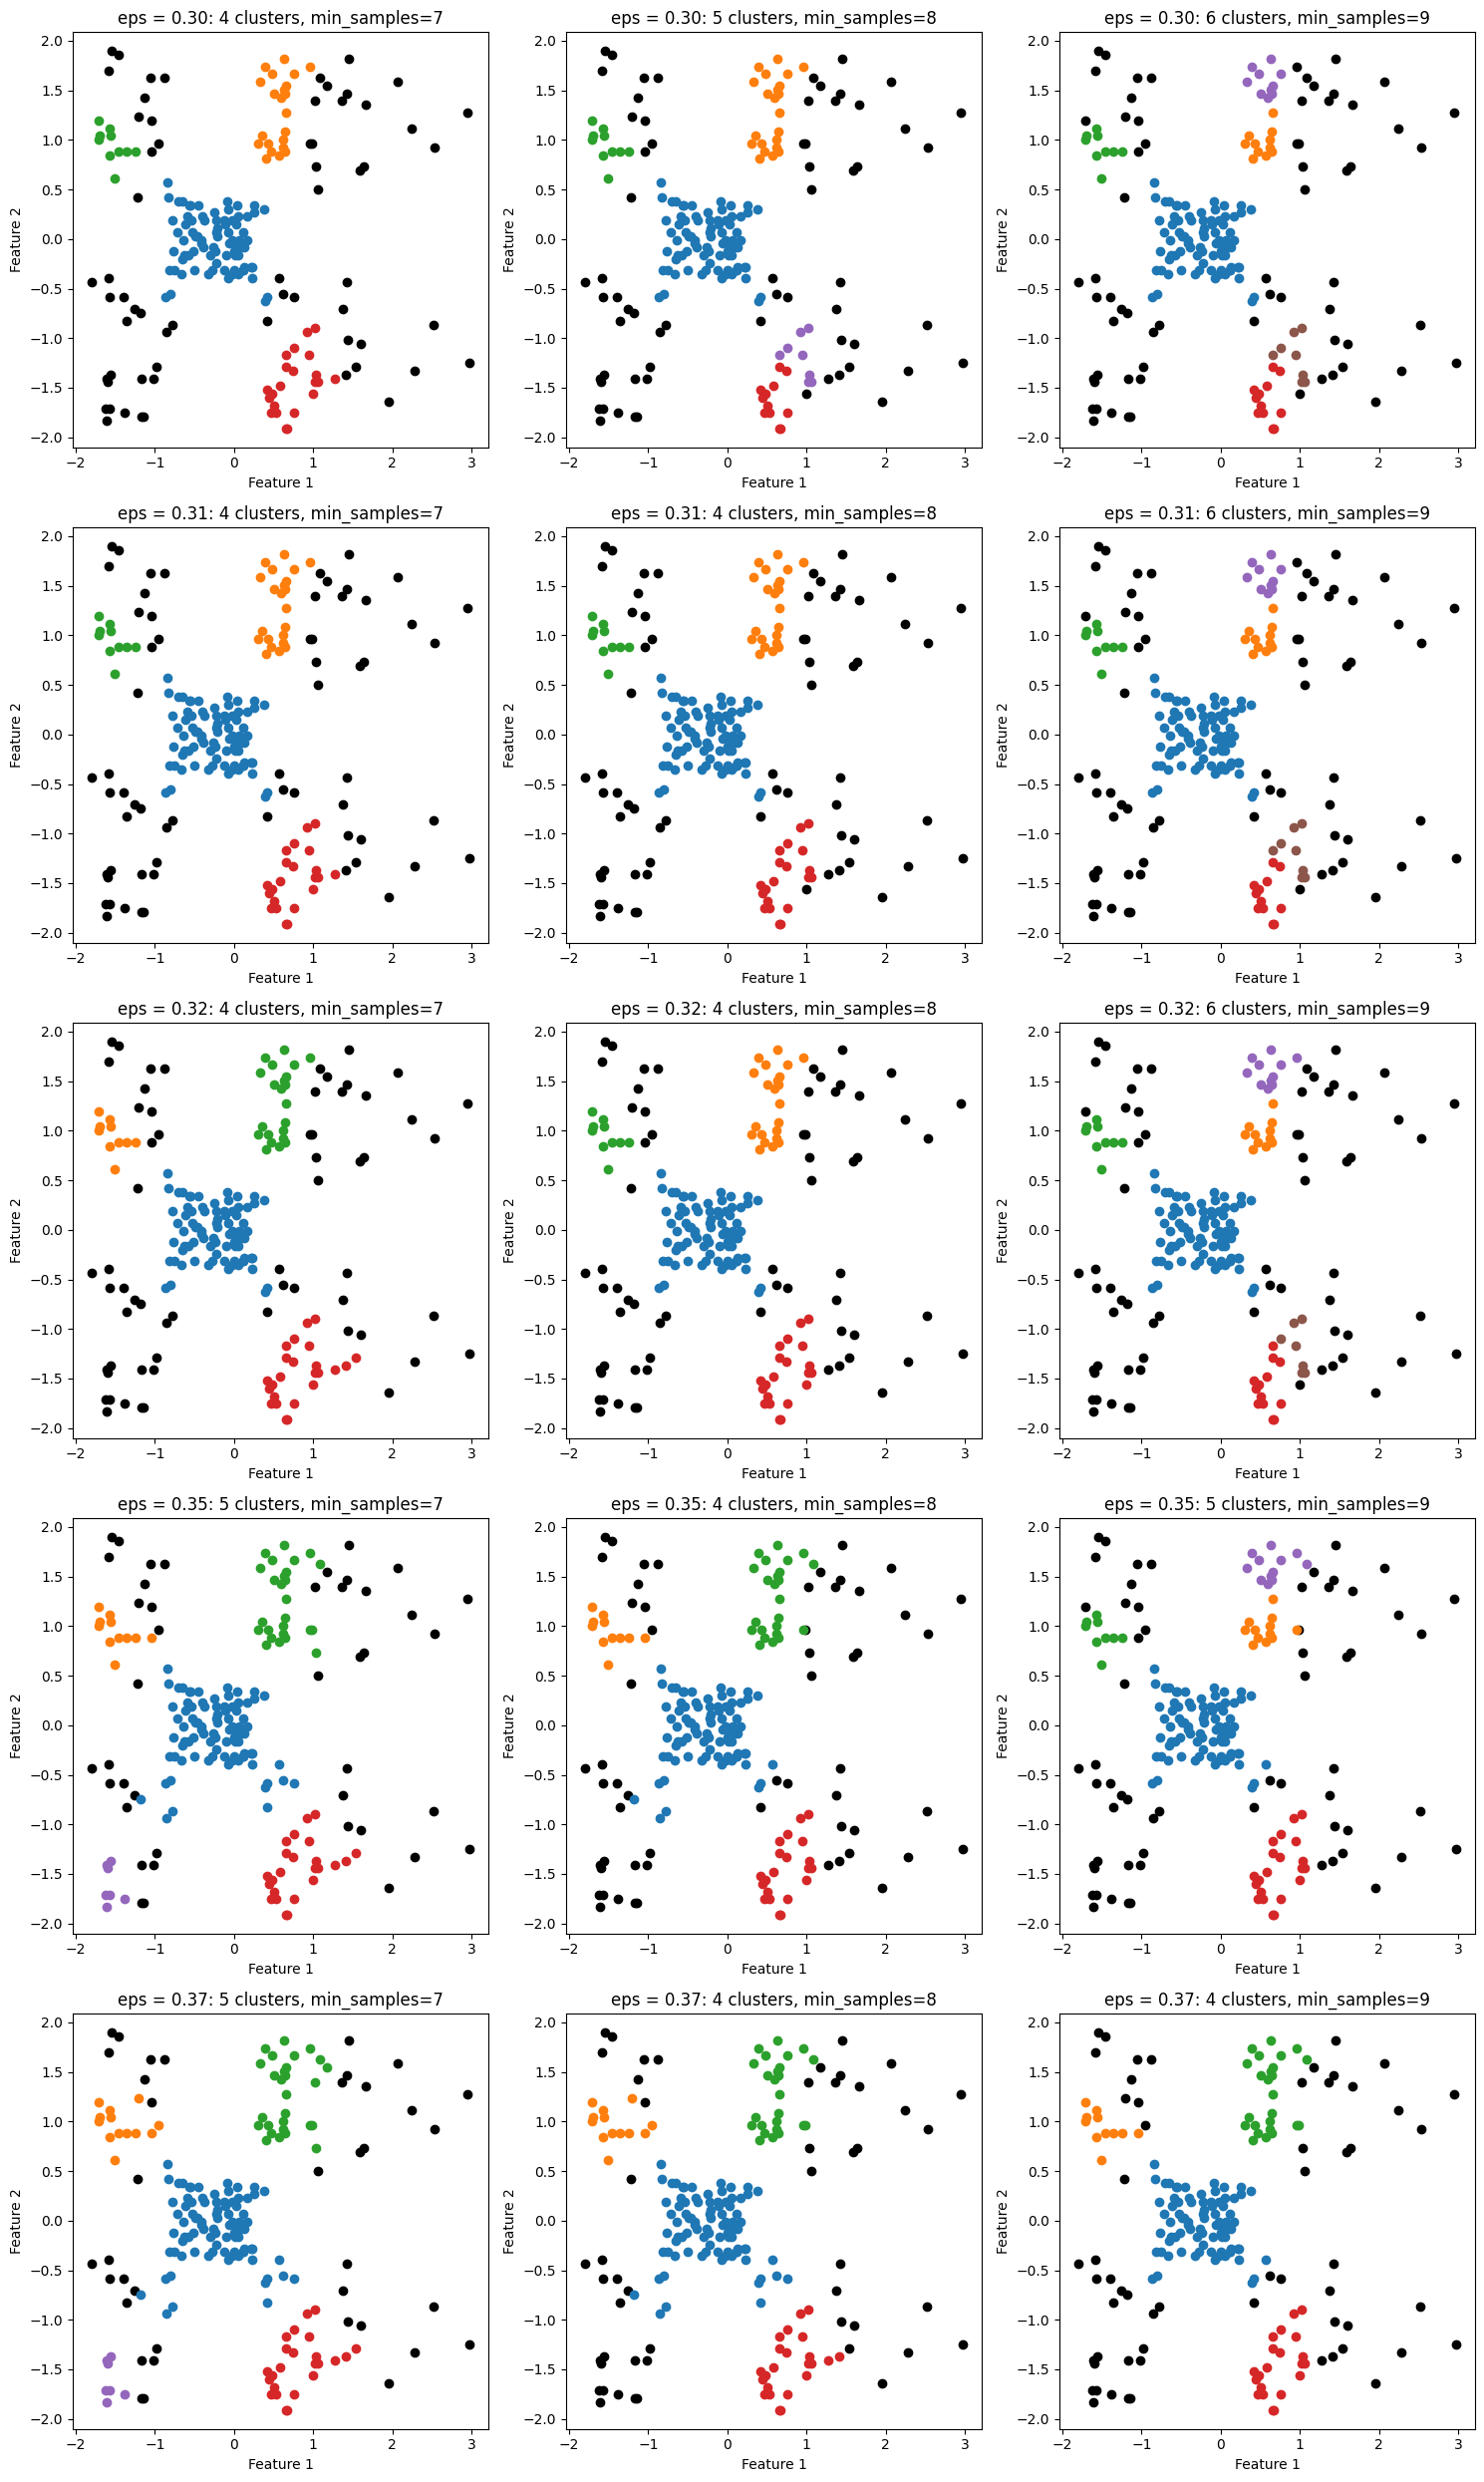

In [89]:
epsilon_list = [0.3, 0.31 , 0.32 ,0.35, 0.37]  
min_samples_list = [7, 8, 9]  
plot_dbscan_across_epsilons(X, epsilon_list, min_samples_list)

#### `Min Samples` y `eps` elegidos:
Vemos entonces que usando min_samples igual a 2 o 4 se encuentran mejores clusters, con menor ruido aunque con mas clusters como se ve a continuacion:

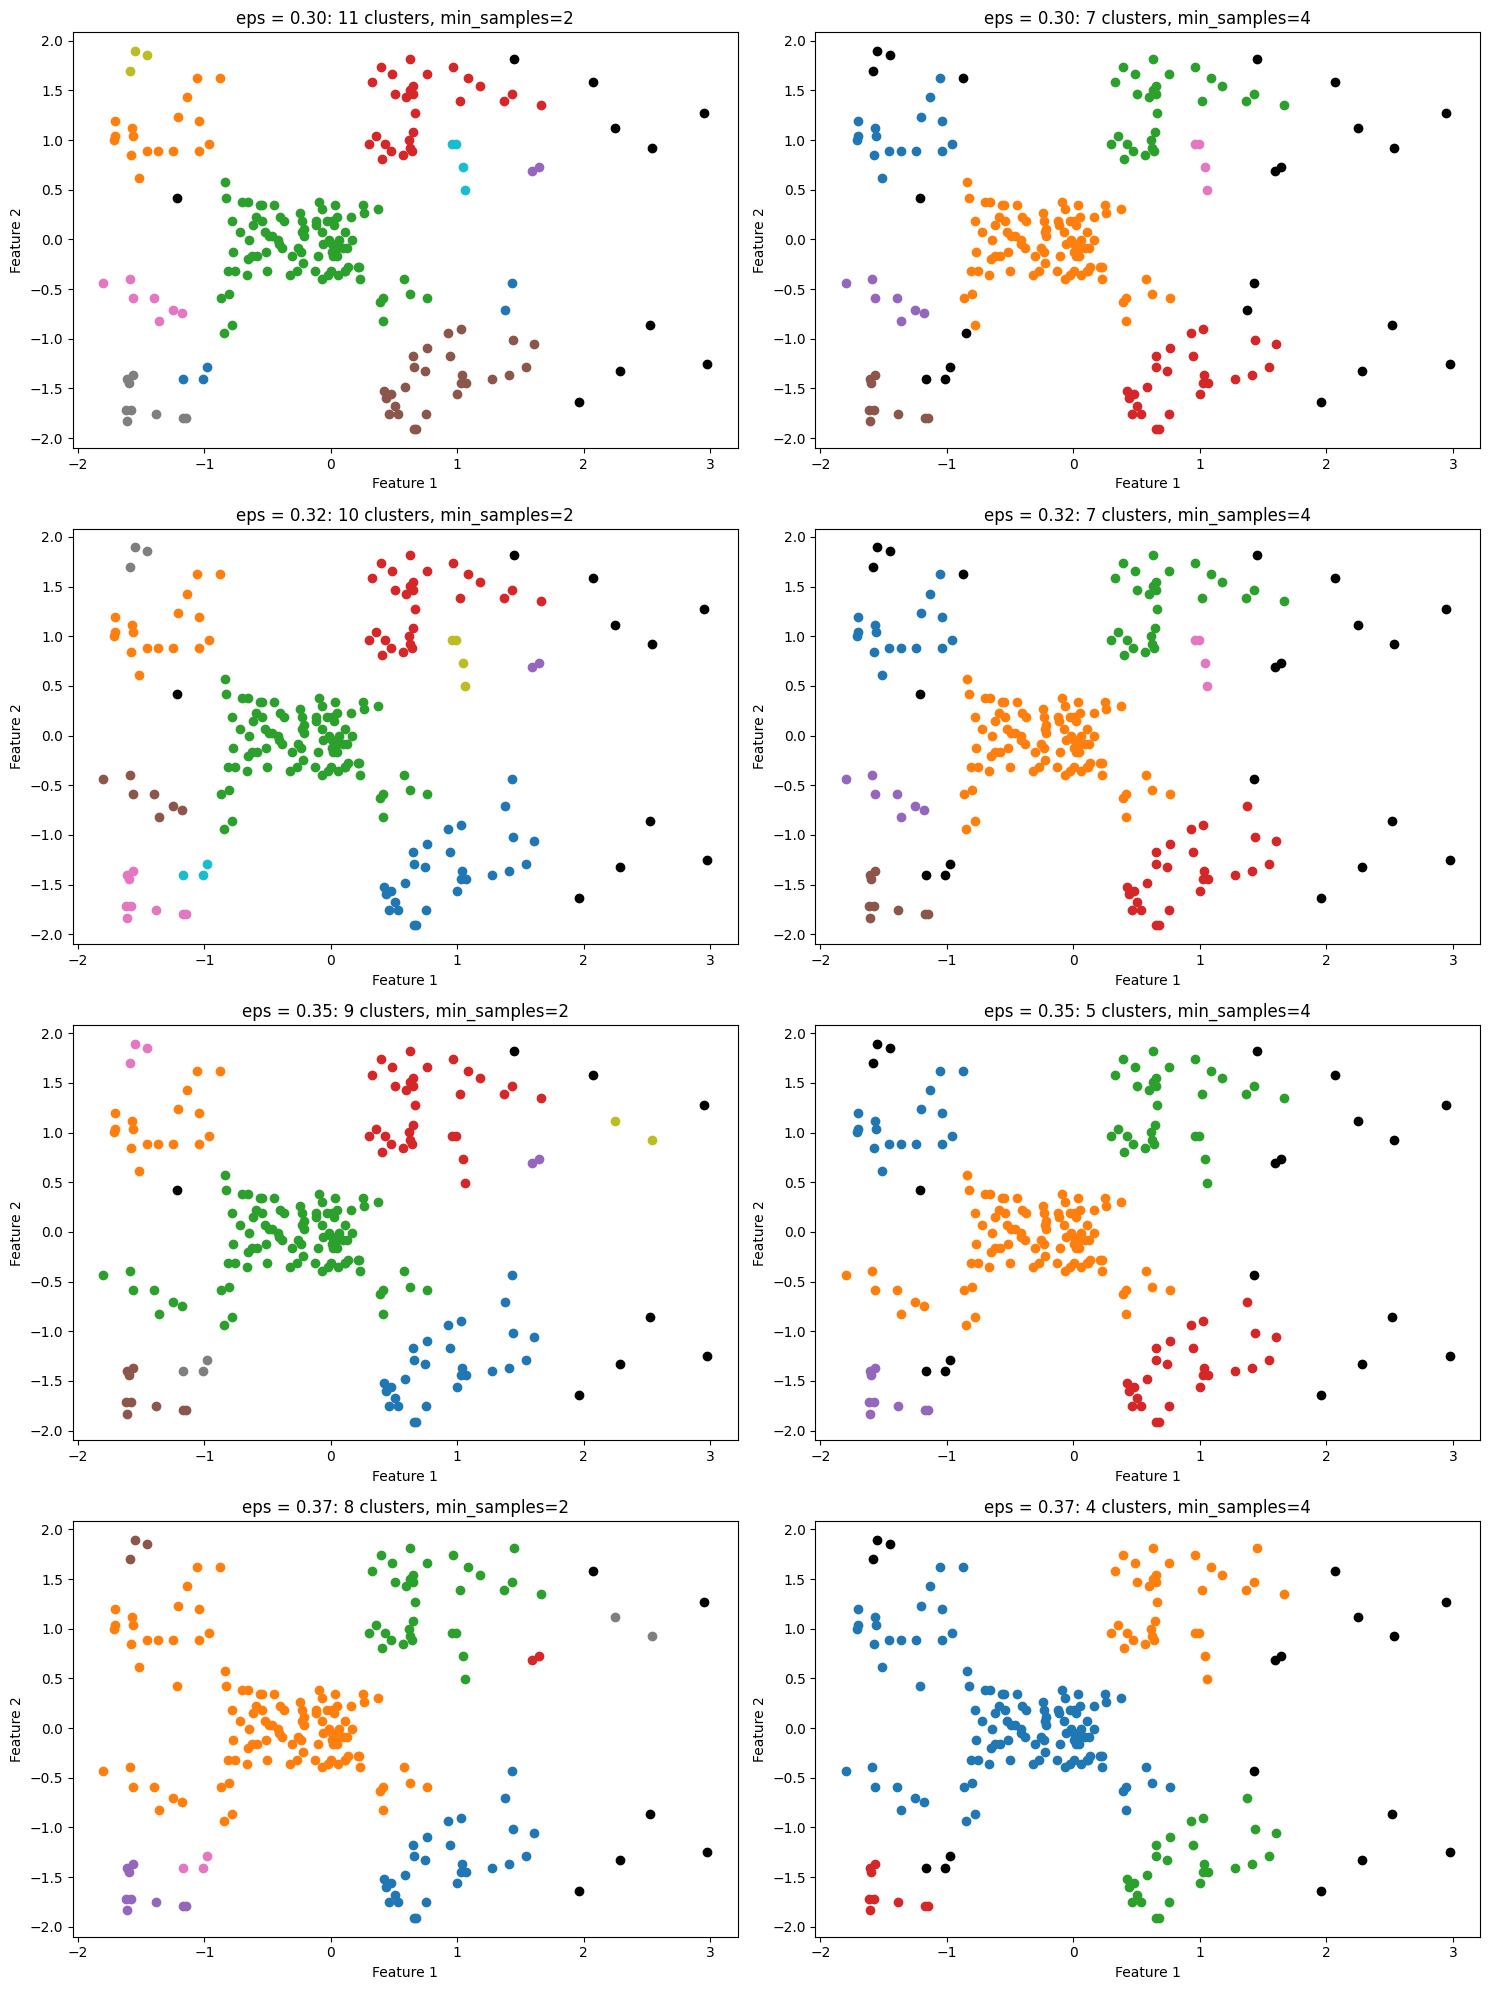

In [90]:
epsilon_list = [0.3, 0.32 ,0.35, 0.37]  
min_samples_list = [2,4]  
plot_dbscan_across_epsilons(X, epsilon_list, min_samples_list)

#### En este caso se decide tomar `min samples` = 4 y `eps` = 0.3

Esto debido a que se tiene menor numero de datos de ruido pero aun asi se separa en un numero de clusters trabajables (7), que en este caso podriamos ver que hay algunos con pocas observaciones, pero all agregar mas observaciones se podria separar de mejor manera el grupo de personas. Esto lo podemos ver a continuacion usando DBScan con los datos elegidos:

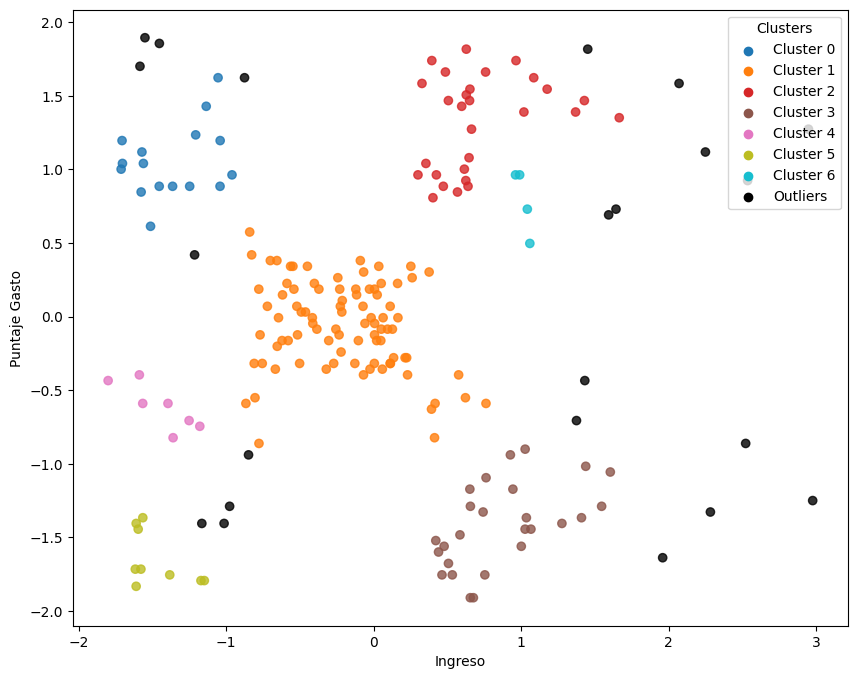

In [91]:
db = DBSCAN(eps=0.3, min_samples=4)
clusters = db.fit_predict(X)

# Definir número de clusters y paleta de colores
num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))

# Asignar colores a los puntos según su cluster
cluster_colors = [colors[cluster] if cluster != -1 else (0, 0, 0, 1) for cluster in clusters]

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 8), dpi=100, facecolor='w', edgecolor='k')
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=cluster_colors, alpha=0.8)

# Crear leyenda manualmente
for cluster_num in range(num_clusters):
    ax.scatter([], [], c=[colors[cluster_num]], label=f'Cluster {cluster_num}')
if -1 in clusters:
    ax.scatter([], [], c='black', label='Outliers')

ax.set_ylabel("Puntaje Gasto")  # Etiqueta para el eje X usando el nombre de la primera columna
ax.set_xlabel("Ingreso")  # Etiqueta para el eje Y usando el nombre de la segunda columna

ax.legend(loc="upper right", title="Clusters")
plt.show()


En este caso se obtienen mas clusters, por esta razon se decide cambiar un poco la estrategia de Marketing

##### Donde enfocar el marketing con mas clusters
Enfocaria una estrategia de marketing en los clusters 1(medio), 3(mayor ingreso & menor puntaje gasto) y 6 (mayor ingreso & buen puntaje de gasto) :


* El cluster 1 aunque con menores ingresos que el cluster 3 tiene mejor puntaje de gasto, y seria posible hacer que aprovechando su capacidad monetaria aumenten aun mas su puntaje de gasto parecido a los clusters de mayor gasto.

* En el cluster 3 tienen un alto ingreso pero bajo puntaje de gasto, por lo que tienen los medios para comprar pero no hacen tantas compras, si enfocamos una campaña de marketing a este grupo podriamos hacer que el puntaje de gasto aumente. Seria una campaña que podria costar mas pero tambien podria dar el mayor retorno si se hace correctamente.

* En el cluster 6 se tiene mismo nivel de ingreso que el 3 pero mayor puntaje de gasto, por lo que podria ser posible subir su nivel de gasto con una estrategia de menor costo

Los demas clusters no valdria la pena utilizar recursos en ellos, pues por ejemplo los cluster 2 y 3 ya tienen un puntaje de gasto alto, y el cluster 1 pueden no tener los medios para subir mucho mas el puntaje de gasto (aunque podria ser posible buscar de que forma hacer que suban al cluster 3, pero puede ser mas dificil solo con marketing) 

### 5. Incorporando más dimensiones

Hasta este momento hemos utilizado solo dos variables para nuestro análisis, sin embargo, la base cuenta con otras variables más: género y edad. Usando las categorías de edad creadas anteriormente incorpore género y grupo etario a su análisis. Genere los grupos utilizando DBSCAN y la distancia de Gower, justificando su elección de `min_samples` y `eps`   ¿Incorporar estas variables, ayuda a la focalización de la estrategia de marketing?

In [93]:
df_datos['Genero_Cat']=df_datos['Genero'].map({'Hombre': 0, 'Mujer': 1})

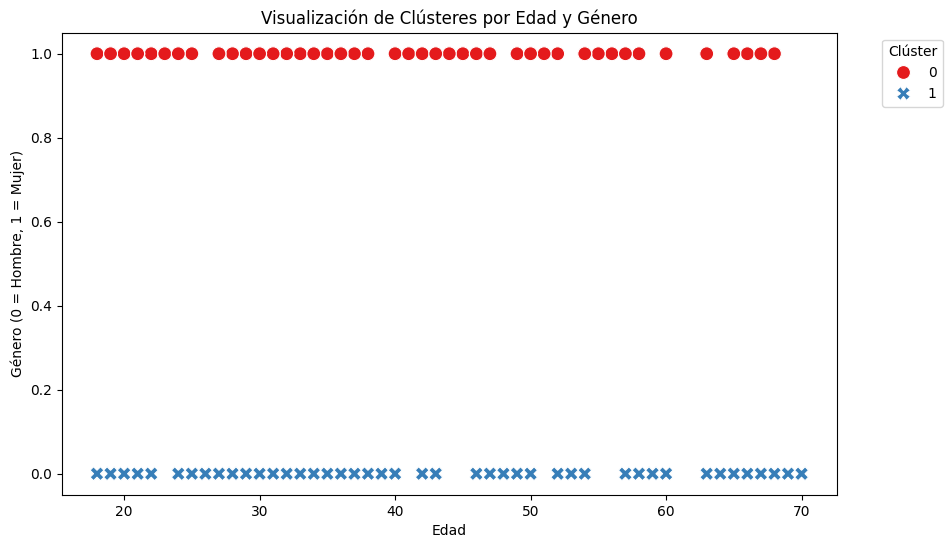

In [94]:
# Utilice este espacio para escribir el código.
import gower



gower_matrix = gower.gower_matrix(df_datos)

min_samples = 4  # 2 veces el número de características (2: edad y género)
eps = 0.3 

db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
clusters = db.fit_predict(gower_matrix)

# Añadir los clusters al DataFrame original
df_datos['Cluster'] = clusters


plt.figure(figsize=(10, 6))

# Creamos un gráfico de dispersión donde el eje X es el rango de edad y el eje Y es el género
sns.scatterplot(
    x='Edad', 
    y='Genero_Cat', 
    hue='Cluster',  # Coloreamos por clúster
    palette='Set1',  # Paleta de colores para los clústeres
    data=df_datos,
    style='Cluster',  # Estilos diferentes para cada clúster
    s=100  # Tamaño de los puntos
)

# Ajustamos los ejes y etiquetas
plt.xlabel('Edad')
plt.ylabel('Género (0 = Hombre, 1 = Mujer)')
plt.title('Visualización de Clústeres por Edad y Género')
plt.legend(title='Clúster', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

(Utilice este espacio para describir su procedimiento)